In [40]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import calendar
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from numpy import array
from math import sqrt
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import keras.backend as K
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import kruskal, shapiro, levene
import seaborn as sns
from random import random
#!pip install pmdarima --quiet
import pmdarima as pm

# Code adapted from https://medium.com/data-science/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6
# Plot data to view
def plot_data(df, feature):
    plt.figure(figsize=(15,7))
    plt.title(str(feature)+" by Month")
    plt.xlabel('Month')
    plt.ylabel(str(feature))
    plt.plot(df)
    plt.show()

#Determine rolling statistics to find trends
def rolling_statistics(df):
    df["rolling_avg"] = df[df.columns[0]].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
    df["rolling_std"] = df[df.columns[0]].rolling(window=12).std()

    #Plot rolling statistics
    plt.figure(figsize=(15,7))
    plt.plot(df, color='#379BDB', label='Original')
    plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
    plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#Augmented Dickey-Fuller Test to test if the time series is stationary
#If ADF has p <= 0.05, data are stationary
def ADF(df, feature):
    print('Results of Dickey Fuller Test for '+feature+':')
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

    return dfoutput

def add_padding(y):

    # Create rows of padding with zeros
    if isinstance(y[0][0], float) or isinstance(y[0][0], int):
        n_vars = 1
    else:
        n_vars = len(y[0][0])

    if n_vars == 1:
        padding = 0 * n_vars
    else:
        padding = [0 * n_vars]

    data = []
    
    for p in range(len(y)):
        for q in range(len(y[0])):
            data.append(y[p][q])
        
        for r in range(12):
            data.append(padding)

    return data

# Standard ARIMA Model
def fit_ARIMA_model(temp, temp_val, temp_test, sh, sh_val, sh_test, n_seq):

    # Check RMSE for each fold
    cv1_errors = []
    cv1_mae = []
    cv1_mape = []
    cv1_r2 = []
    cv2_errors = []
    cv2_mae = []
    cv2_mape = []
    cv2_r2 = []

    dates = pd.date_range(start='2006-01-01', periods=179, freq='M')

    y1 = []
    y2 = []
    
    y1_list = temp[0]
    y2_list = sh[0]
    y1_val = temp_val[0]
    y1_test = temp_test[0]
    y2_val = sh_val[0]
    y2_test = sh_test[0]

    print(len(temp[0]))
    print(len(temp_val[0]))
    print(len(temp_test[0]))
    print(len(y1_list))

    for q in range(10):
        y1_list.append(y1_val[q])
        y2_list.append(y2_val[q])

    for r in range(11):
        y1_list.append(y1_test[r])
        y2_list.append(y2_test[r])

    for j in range(len(y1_list)):
        series1 = pd.Series(y1_list[j])
        series2 = pd.Series(y2_list[j])
        y1 = np.array(y1_list[j])
        y2 = np.array(y2_list[j])

        # Reconstruct the data frame with standardized values
        data = pd.DataFrame({'y1': y1, 'y2': y2}, index=dates)

        model1 = pm.auto_arima(y1, start_p=0, start_q=0, exogenous=None, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=False, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )

        model2 = pm.auto_arima(y2, start_p=0, start_q=0, exogenous=None, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=False, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )
                
        model1_fit = model1.fit(y1_val[0])
        print(model1_fit.summary())

        model2_fit = model2.fit(y2_val[0])
        print(model2_fit.summary())

        #Make predictions
        predictions1 = model1_fit.predict(start=len(y1_list[-n_seq]), end=len(series1)-1)

        #Make predictions
        predictions2 = model2_fit.predict(start=len(y2_list[-n_seq]), end=len(series2)-1)

        # Get actual values to compare against predictions
        actual1 = []
        for i1 in range(10):
            xtwo = y1_list[j]
            ztwo = []
            for c1 in reversed(range(n_seq)):
                ztwo.append(xtwo[len(series1)-1-c1])
            if n_seq == 1:
                actual1.append(ztwo[0])
            else:
                actual1.append(ztwo)

        actual2 = []
        for i2 in range(10):
            xthree = y2_list[j]
            zthree = []
            for c2 in reversed(range(n_seq)):
                zthree.append(xthree[len(series2)-1-c2])
            if n_seq == 1:
                actual2.append(zthree[0])
            else:
                actual2.append(zthree)

        print("Actuals:")
        print(actual1)
        print(actual2)
        print("Predicted:")
        print(predictions1)
        print(predictions2)
                    
        #Calculate the Root Mean Square Error (RMSE)
        mse1 = mean_squared_error(actual1, predictions1)
        rmse1 = np.sqrt(mse1)
        mae1 = mean_absolute_error(actual1, predictions1)
        mape1 = mean_absolute_percentage_error(actual1, predictions1)
        r2a = r2_score(actual1, predictions1)
        cv1_errors.append(rmse1)
        cv1_mae.append(mae1)
        cv1_mape.append(mape1)
        cv1_r2.append(r2a)

        #Calculate the Root Mean Square Error (RMSE)
        mse2 = mean_squared_error(actual2, predictions2)
        rmse2 = np.sqrt(mse2)
        mae2 = mean_absolute_error(actual2, predictions2)
        mape2 = mean_absolute_percentage_error(actual2, predictions2)
        r2b = r2_score(actual2, predictions2)
        cv2_errors.append(rmse2)
        cv2_mae.append(mae2)
        cv2_mape.append(mape2)
        cv2_r2.append(r2b)

        print("Weather Station "+str(j)+" Temperature RMSE value: "+str(rmse1))
        print("Weather Station "+str(j)+" Specific Humidity RMSE value: "+str(rmse2))        
        
    print("Temperature Metrics:")
    print("RMSE values:")
    print(cv1_errors)
    print("MAE values:")
    print(cv1_mae)
    print("MAPE values:")
    print(cv1_mape)
    print("R2 scores:")
    print(cv1_r2)
    print("")
    print("Specific Humidity Metrics:")
    print("RMSE values:")
    print(cv2_errors)
    print("MAE values:")
    print(cv2_mae)
    print("MAPE values:")
    print(cv2_mape)
    print("R2 scores:")
    print(cv2_r2)

    print("RMSE values for SARIMAX model:")
    print("Temperature:")
    print(cv1_errors)
    print("Specific Humidity:")
    print(cv2_errors)
            
    # Print evaluation results
    print("Temperature:")
    print("Average of RMSE fold values: "+str(np.mean(cv1_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv1_errors)))
    print(f"Mean Absolute Error: {np.mean(cv1_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv1_mape)}")
    print(f"R2 Score: {np.mean(cv1_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv1_errors)))
    print("Specific Humidity:")
    print("Average of RMSE fold values: "+str(np.mean(cv2_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv2_errors)))
    print(f"Mean Absolute Error: {np.mean(cv2_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv2_mape)}")
    print(f"R2 Score: {np.mean(cv2_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv2_errors)))
    
    return model1, model2

# ARIMA Model
def fit_auto_ARIMA_model(temp, temp_val, temp_test, sh, sh_val, sh_test, n_seq):

    # Check RMSE for each fold
    cv1_errors = []
    cv1_mae = []
    cv1_mape = []
    cv1_r2 = []
    cv2_errors = []
    cv2_mae = []
    cv2_mape = []
    cv2_r2 = []

    dates = pd.date_range(start='2006-01-01', periods=179, freq='M')

    y1 = []
    y2 = []
    
    for k in range(5):
        y1_list = temp[k]
        y2_list = sh[k]
        y1_val = temp_val[k]
        y1_test = temp_test[k]
        y2_val = sh_val[k]
        y2_test = sh_test[k]
        for j in range(len(y1_list)):
            series1 = pd.Series(y1_list[j])
            series2 = pd.Series(y2_list[j])
            y1 = np.array(y1_list[j])
            y2 = np.array(y2_list[j])

            # Reconstruct the data frame with standardized values
            data = pd.DataFrame({'y1': y1, 'y2': y2}, index=dates)

            model1 = pm.auto_arima(y1, start_p=0, start_q=0, exogenous=None, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=False, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )

            model2 = pm.auto_arima(y2, start_p=0, start_q=0, exogenous=None, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=False, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )
                
            model1_fit = model1.fit(y1_val[0])
            print(model1_fit.summary())

            model2_fit = model2.fit(y2_val[0])
            print(model2_fit.summary())

            #Make predictions
            predictions1 = model1_fit.predict(start=len(y1_list[-n_seq]), end=len(series1)-1)

            #Make predictions
            predictions2 = model2_fit.predict(start=len(y2_list[-n_seq]), end=len(series2)-1)

            # Get actual values to compare against predictions
            actual1 = []
            for i1 in range(len(temp_val[k])):
                xtwo = y1_val[0]
                ztwo = []
                for c1 in reversed(range(n_seq)):
                    ztwo.append(xtwo[len(series1)-1-c1])
                if n_seq == 1:
                    actual1.append(ztwo[0])
                else:
                    actual1.append(ztwo)

            actual2 = []
            for i2 in range(10):
                xthree = y2_val[0]
                zthree = []
                for c2 in reversed(range(n_seq)):
                    zthree.append(xthree[len(series2)-1-c2])
                if n_seq == 1:
                    actual2.append(zthree[0])
                else:
                    actual2.append(zthree)

            print("Actuals:")
            print(actual1)
            print(actual2)
            print("Predicted:")
            print(predictions1)
            print(predictions2)
                    
            #Calculate the Root Mean Square Error (RMSE)
            mse1 = mean_squared_error(actual1, predictions1)
            rmse1 = np.sqrt(mse1)
            mae1 = mean_absolute_error(actual1, predictions1)
            mape1 = mean_absolute_percentage_error(actual1, predictions1)
            r2a = r2_score(actual1, predictions1)
            cv1_errors.append(rmse1)
            cv1_mae.append(mae1)
            cv1_mape.append(mape1)
            cv1_r2.append(r2a)

            #Calculate the Root Mean Square Error (RMSE)
            mse2 = mean_squared_error(actual2, predictions2)
            rmse2 = np.sqrt(mse2)
            mae2 = mean_absolute_error(actual2, predictions2)
            mape2 = mean_absolute_percentage_error(actual2, predictions2)
            r2b = r2_score(actual2, predictions2)
            cv2_errors.append(rmse2)
            cv2_mae.append(mae2)
            cv2_mape.append(mape2)
            cv2_r2.append(r2b)

            print("Weather Station "+str(j)+" Temperature RMSE value: "+str(rmse1))
            print("Weather Station "+str(j)+" Specific Humidity RMSE value: "+str(rmse2))        
        
        print("Fold "+str(k)+":")
        print("Temperature Metrics:")
        print("RMSE values:")
        print(cv1_errors)
        print("MAE values:")
        print(cv1_mae)
        print("MAPE values:")
        print(cv1_mape)
        print("R2 scores:")
        print(cv1_r2)
        print("")
        print("Specific Humidity Metrics:")
        print("RMSE values:")
        print(cv2_errors)
        print("MAE values:")
        print(cv2_mae)
        print("MAPE values:")
        print(cv2_mape)
        print("R2 scores:")
        print(cv2_r2)

    print("RMSE values for SARIMAX model:")
    print("Temperature:")
    print(cv1_errors)
    print("Specific Humidity:")
    print(cv2_errors)
            
    # Print evaluation results
    print("Temperature:")
    print("Average of RMSE fold values: "+str(np.mean(cv1_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv1_errors)))
    print(f"Mean Absolute Error: {np.mean(cv1_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv1_mape)}")
    print(f"R2 Score: {np.mean(cv1_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv1_errors)))
    print("Specific Humidity:")
    print("Average of RMSE fold values: "+str(np.mean(cv2_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv2_errors)))
    print(f"Mean Absolute Error: {np.mean(cv2_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv2_mape)}")
    print(f"R2 Score: {np.mean(cv2_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv2_errors)))
    
    return model1, model2
    
# SARIMAX Model
def fit_SARIMAX_model(temp, temp_val, temp_test, sh, sh_val, sh_test, PC1, PC1_val, PC1_test, PC2, PC2_val, PC2_test, PC3, PC3_val, PC3_test, n_seq):

    # Check RMSE for each fold
    cv1_errors = []
    cv1_mae = []
    cv1_mape = []
    cv1_r2 = []
    cv2_errors = []
    cv2_mae = []
    cv2_mape = []
    cv2_r2 = []

    dates = pd.date_range(start='2006-01-01', periods=179, freq='M')

    y1 = []
    y2 = []
    exog1 = []
    exog2 = []
    exog3 = []
    
    y1_list = temp[0]
    y2_list = sh[0]
    y1_val = temp_val[0]
    y1_test = temp_test[0]
    y2_val = sh_val[0]
    y2_test = sh_test[0]
    PC1_list = PC1[0]
    PC1_list_val = PC1_val[0]
    PC1_list_test = PC1_test[0]
    PC2_list = PC2[0]
    PC2_list_val = PC2_val[0]
    PC2_list_test = PC2_test[0]
    PC3_list = PC3[0]
    PC3_list_val = PC3_val[0]
    PC3_list_test = PC3_test[0]

    print(len(temp[0]))
    print(len(temp_val[0]))
    print(len(temp_test[0]))
    print(len(y1_list))

    for q in range(10):
        y1_list.append(y1_val[q])
        y2_list.append(y2_val[q])
        PC1_list.append(PC1_list_val[q])
        PC2_list.append(PC2_list_val[q])
        PC3_list.append(PC3_list_val[q])

    for r in range(11):
        y1_list.append(y1_test[r])
        y2_list.append(y2_test[r])
        PC1_list.append(PC1_list_test[r])
        PC2_list.append(PC2_list_test[r])
        PC3_list.append(PC3_list_test[r])

    for j in range(len(y1_list)):
        series1 = pd.Series(y1_list[j])
        series2 = pd.Series(y2_list[j])
        y1 = np.array(y1_list[j])
        y2 = np.array(y2_list[j])
        exog1 = np.array(PC1_list[j])
        exog2 = np.array(PC2_list[j])
        exog3 = np.array(PC3_list[j])

        # Reconstruct the data frame with standardized values
        data = pd.DataFrame({'y1': y1, 'y2': y2, 'exog1': exog1, 'exog2': exog2, 'exog3': exog3}, index=dates)

        # Define the exogenous variables
        exog = data[['exog1', 'exog2', 'exog3']]

        model1 = pm.auto_arima(y1, start_p=0, start_q=0, exogenous=exog, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=True, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )

        model2 = pm.auto_arima(y2, start_p=0, start_q=0, exogenous=exog, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=True, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )
                
        model1_fit = model1.fit(y1_val[0])
        print(model1_fit.summary())

        model2_fit = model2.fit(y2_val[0])
        print(model2_fit.summary())

        #Make predictions
        predictions1 = model1_fit.predict(start=len(y1_list[-n_seq]), end=len(series1)-1)

        #Make predictions
        predictions2 = model2_fit.predict(start=len(y2_list[-n_seq]), end=len(series2)-1)

        # Get actual values to compare against predictions
        actual1 = []
        for i1 in range(10):
            xtwo = y1_list[j]
            ztwo = []
            for c1 in reversed(range(n_seq)):
                ztwo.append(xtwo[len(series1)-1-c1])
            if n_seq == 1:
                actual1.append(ztwo[0])
            else:
                actual1.append(ztwo)

        actual2 = []
        for i2 in range(10):
            xthree = y2_list[j]
            zthree = []
            for c2 in reversed(range(n_seq)):
                zthree.append(xthree[len(series2)-1-c2])
            if n_seq == 1:
                actual2.append(zthree[0])
            else:
                actual2.append(zthree)

        print("Actuals:")
        print(actual1)
        print(actual2)
        print("Predicted:")
        print(predictions1)
        print(predictions2)
                    
        #Calculate the Root Mean Square Error (RMSE)
        mse1 = mean_squared_error(actual1, predictions1)
        rmse1 = np.sqrt(mse1)
        mae1 = mean_absolute_error(actual1, predictions1)
        mape1 = mean_absolute_percentage_error(actual1, predictions1)
        r2a = r2_score(actual1, predictions1)
        cv1_errors.append(rmse1)
        cv1_mae.append(mae1)
        cv1_mape.append(mape1)
        cv1_r2.append(r2a)

        #Calculate the Root Mean Square Error (RMSE)
        mse2 = mean_squared_error(actual2, predictions2)
        rmse2 = np.sqrt(mse2)
        mae2 = mean_absolute_error(actual2, predictions2)
        mape2 = mean_absolute_percentage_error(actual2, predictions2)
        r2b = r2_score(actual2, predictions2)
        cv2_errors.append(rmse2)
        cv2_mae.append(mae2)
        cv2_mape.append(mape2)
        cv2_r2.append(r2b)

        print("Weather Station "+str(j)+" Temperature RMSE value: "+str(rmse1))
        print("Weather Station "+str(j)+" Specific Humidity RMSE value: "+str(rmse2))        
        
    print("Temperature Metrics:")
    print("RMSE values:")
    print(cv1_errors)
    print("MAE values:")
    print(cv1_mae)
    print("MAPE values:")
    print(cv1_mape)
    print("R2 scores:")
    print(cv1_r2)
    print("")
    print("Specific Humidity Metrics:")
    print("RMSE values:")
    print(cv2_errors)
    print("MAE values:")
    print(cv2_mae)
    print("MAPE values:")
    print(cv2_mape)
    print("R2 scores:")
    print(cv2_r2)

    print("RMSE values for SARIMAX model:")
    print("Temperature:")
    print(cv1_errors)
    print("Specific Humidity:")
    print(cv2_errors)
            
    # Print evaluation results
    print("Temperature:")
    print("Average of RMSE fold values: "+str(np.mean(cv1_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv1_errors)))
    print(f"Mean Absolute Error: {np.mean(cv1_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv1_mape)}")
    print(f"R2 Score: {np.mean(cv1_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv1_errors)))
    print("Specific Humidity:")
    print("Average of RMSE fold values: "+str(np.mean(cv2_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv2_errors)))
    print(f"Mean Absolute Error: {np.mean(cv2_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv2_mape)}")
    print(f"R2 Score: {np.mean(cv2_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv2_errors)))
    
    return model1, model2

# SARIMAX Model
def fit_auto_SARIMAX_model(temp, temp_val, temp_test, sh, sh_val, sh_test, PC1, PC1_val, PC1_test, PC2, PC2_val, PC2_test, PC3, PC3_val, PC3_test, n_seq):

    # Check RMSE for each fold
    cv1_errors = []
    cv1_mae = []
    cv1_mape = []
    cv1_r2 = []
    cv2_errors = []
    cv2_mae = []
    cv2_mape = []
    cv2_r2 = []

    dates = pd.date_range(start='2006-01-01', periods=179, freq='M')

    y1 = []
    y2 = []
    exog1 = []
    exog2 = []
    exog3 = []
    
    for k in range(5):
        y1_list = temp[k]
        y2_list = sh[k]
        y1_val = temp_val[k]
        y1_test = temp_test[k]
        y2_val = sh_val[k]
        y2_test = sh_test[k]
        PC1_list = PC1[k]
        PC2_list = PC2[k]
        PC3_list = PC3[k]
        for j in range(len(y1_list)):
            series1 = pd.Series(y1_list[j])
            series2 = pd.Series(y2_list[j])
            y1 = np.array(y1_list[j])
            y2 = np.array(y2_list[j])
            exog1 = np.array(PC1_list[j])
            exog2 = np.array(PC2_list[j])
            exog3 = np.array(PC3_list[j])

            # Reconstruct the data frame with standardized values
            data = pd.DataFrame({'y1': y1, 'y2': y2, 'exog1': exog1, 'exog2': exog2, 'exog3': exog3}, index=dates)

            # Define the exogenous variables
            exog = data[['exog1', 'exog2', 'exog3']]

            model1 = pm.auto_arima(y1, start_p=0, start_q=0, exogenous=exog, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=True, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )

            model2 = pm.auto_arima(y2, start_p=0, start_q=0, exogenous=exog, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=True, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )
                
            model1_fit = model1.fit(y1_val[0])
            print(model1_fit.summary())

            model2_fit = model2.fit(y2_val[0])
            print(model2_fit.summary())

            #Make predictions
            predictions1 = model1_fit.predict(start=len(y1_list[-n_seq]), end=len(series1)-1)

            #Make predictions
            predictions2 = model2_fit.predict(start=len(y2_list[-n_seq]), end=len(series2)-1)

            # Get actual values to compare against predictions
            actual1 = []
            for i1 in range(len(temp_val[k])):
                xtwo = y1_val[0]
                ztwo = []
                for c1 in reversed(range(n_seq)):
                    ztwo.append(xtwo[len(series1)-1-c1])
                if n_seq == 1:
                    actual1.append(ztwo[0])
                else:
                    actual1.append(ztwo)

            actual2 = []
            for i2 in range(10):
                xthree = y2_val[0]
                zthree = []
                for c2 in reversed(range(n_seq)):
                    zthree.append(xthree[len(series2)-1-c2])
                if n_seq == 1:
                    actual2.append(zthree[0])
                else:
                    actual2.append(zthree)

            print("Actuals:")
            print(actual1)
            print(actual2)
            print("Predicted:")
            print(predictions1)
            print(predictions2)
                    
            #Calculate the Root Mean Square Error (RMSE)
            mse1 = mean_squared_error(actual1, predictions1)
            rmse1 = np.sqrt(mse1)
            mae1 = mean_absolute_error(actual1, predictions1)
            mape1 = mean_absolute_percentage_error(actual1, predictions1)
            r2a = r2_score(actual1, predictions1)
            cv1_errors.append(rmse1)
            cv1_mae.append(mae1)
            cv1_mape.append(mape1)
            cv1_r2.append(r2a)

            #Calculate the Root Mean Square Error (RMSE)
            mse2 = mean_squared_error(actual2, predictions2)
            rmse2 = np.sqrt(mse2)
            mae2 = mean_absolute_error(actual2, predictions2)
            mape2 = mean_absolute_percentage_error(actual2, predictions2)
            r2b = r2_score(actual2, predictions2)
            cv2_errors.append(rmse2)
            cv2_mae.append(mae2)
            cv2_mape.append(mape2)
            cv2_r2.append(r2b)

            print("Weather Station "+str(j)+" Temperature RMSE value: "+str(rmse1))
            print("Weather Station "+str(j)+" Specific Humidity RMSE value: "+str(rmse2))        
        
        print("Fold "+str(k)+":")
        print("Temperature Metrics:")
        print("RMSE values:")
        print(cv1_errors)
        print("MAE values:")
        print(cv1_mae)
        print("MAPE values:")
        print(cv1_mape)
        print("R2 scores:")
        print(cv1_r2)
        print("")
        print("Specific Humidity Metrics:")
        print("RMSE values:")
        print(cv2_errors)
        print("MAE values:")
        print(cv2_mae)
        print("MAPE values:")
        print(cv2_mape)
        print("R2 scores:")
        print(cv2_r2)

    print("RMSE values for SARIMAX model:")
    print("Temperature:")
    print(cv1_errors)
    print("Specific Humidity:")
    print(cv2_errors)
            
    # Print evaluation results
    print("Temperature:")
    print("Average of RMSE fold values: "+str(np.mean(cv1_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv1_errors)))
    print(f"Mean Absolute Error: {np.mean(cv1_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv1_mape)}")
    print(f"R2 Score: {np.mean(cv1_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv1_errors)))
    print("Specific Humidity:")
    print("Average of RMSE fold values: "+str(np.mean(cv2_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv2_errors)))
    print(f"Mean Absolute Error: {np.mean(cv2_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv2_mape)}")
    print(f"R2 Score: {np.mean(cv2_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv2_errors)))
    
    return model1, model2

def plot_diagnostics(model):
    model.plot_diagnostics(figsize=(15,12))
    plt.show
    
def ARIMA_forecast(ARIMA_model, df, periods=12):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make a series for plotting purposes
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df, color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA Forecast")
    plt.show()

    return fitted_series, lower_series, upper_series

def SARIMAX_forecast(SARIMAX_model, df, exog, periods=12):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=exog)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df, color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX Forecast")
    plt.show()

    return fitted_series, lower_series, upper_series

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))

# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# transform series into training sets
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        train.append([scaled_values_batch])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([scaled_values_batch])
        else:
            validation.append([scaled_values_batch])
    
    return validation, test

def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))

def transform_data(data, n_lag, n_seq):
    
    X_row = []
    y_row = []
    temp_row = []
    sh_row = []
    PC1_row = []
    PC2_row = []
    PC3_row = []
    for j in range(len(data)):
        X2 = data[j]
        y2 = pd.DataFrame(X2[n_seq:n_lag+n_seq])
        X_row.append(pd.DataFrame(X2[:n_lag]))
        temp_row.append(X_row[j][X_row[j].columns[0]])
        sh_row.append(X_row[j][X_row[j].columns[1]])
        PC1_row.append(X_row[j][X_row[j].columns[2]])
        PC2_row.append(X_row[j][X_row[j].columns[3]])
        PC3_row.append(X_row[j][X_row[j].columns[4]])
        y_row.append(y2[y2.columns[0]])

    return X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row

#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])

#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])

train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10

#X1 = slp	
#X2 = wbt	
#X3 = water	
#X4 = GHI
#X5 = WDSP
#X6 = PRCP	
#X7 = SNDP	
#X8 = Region	
#X9 = SA	
#X10 = ONI

# Get the current working directory 
current_directory = os.getcwd() 

# Print the current working directory 
print(current_directory)

# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)

filename = path + 'Final_Monthly_Dataset.csv'

# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)

# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['date', 'latitude', 'longitude', 'elevation'], axis=1)

results_df = df_trimmed

# Calculate principal components excluding response variables
results_df['PC1']=-0.0004514*results_df['slp']+0.03194*results_df['wet_bulb_temperature']-0.04343*results_df['water']+0.002243*results_df['GHI']-0.02252*results_df['WDSP']
+0.9877*results_df['PRCP']-0.2265*results_df['SNDP']+0.006144*results_df['region']-0.0001488*results_df['solar_activity']+0.02943*results_df['ONI']
results_df['PC2']=0.0001702*results_df['slp']+0.005484*results_df['wet_bulb_temperature']+0.2057*results_df['water']-0.0003188*results_df['GHI']-0.02584*results_df['WDSP']
+1.6963*results_df['PRCP']-0.05890*results_df['SNDP']+0.05809*results_df['region']+1.9748*results_df['solar_activity']+0.03686*results_df['ONI']
results_df['PC3']=-0.00006323*results_df['slp']-0.001180*results_df['wet_bulb_temperature']-0.02384*results_df['water']-0.00002833*results_df['GHI']+0.01170*results_df['WDSP']
+0.5204*results_df['PRCP']+0.4791*results_df['SNDP']-0.004318*results_df['region']+0.008271*results_df['solar_activity']+0.8765*results_df['ONI']

# Drop columns that compose principal components
results_df = results_df.drop(['slp', 'wet_bulb_temperature', 'water', 'GHI', 'WDSP', 'PRCP', 'SNDP', 'region', 'solar_activity', 'ONI'], axis=1)

print(results_df)

print(results_df.columns)

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = results_df[results_df['file_id'] == i].drop(['file_id', 'Year', 'Month'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = [] # Holds 5 folds, each with 84 different weather stations, 227 time steps, and n_vars features 
train_y = [] # Holds 5 folds, each with 84 different weather stations, 227 time steps, and 1 feature (response variable)
val_X = [] # Holds 5 folds, each with 21 different weather stations, 227 time steps, and n_vars features 
val_y = [] # Holds 5 folds, each with 21 different weather stations, 227 time steps, and 1 feature (response variable)
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
        val_X_rows.append(X[j])
        val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows)

#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)    

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])

    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
       file_id  temperatures  specific_humidity    Year  Month       PC1  \
0         6501         12.21               5.39  2006.0    1.0 -0.155299   
1         6501          8.17               4.30  2006.0    2.0 -0.193200   
2         6501         15.68               6.51  2006.0    3.0  0.093451   
3         6501         22.46              10.21  2006.0    4.0  0.456252   
4         6501         23.66              11.74  2006.0    5.0  0.566777   
...        ...           ...                ...     ...    ...       ...   
24057     9858         28.60              15.21  2024.0    7.0       NaN   
24058     9858         29.11              15.15  2024.0    8.0       NaN   
24059     9858         24.57              10.72  2024.0    9.0       NaN   
24060     9858         21.16               6.99  2024.0   10.0       NaN   
24061     9

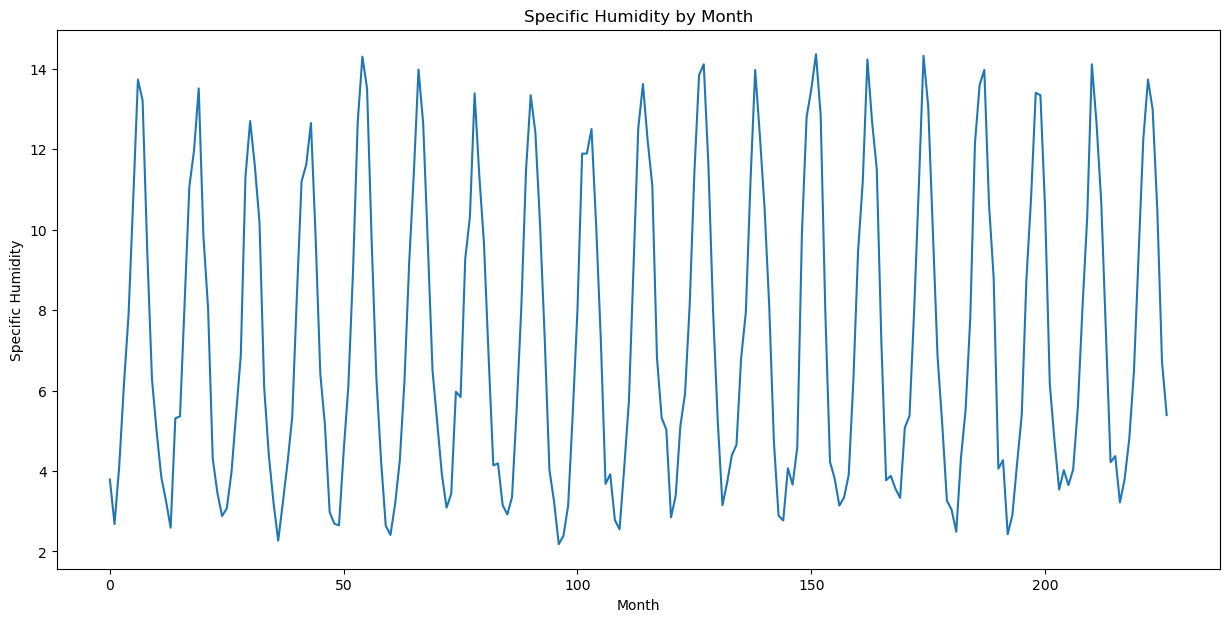

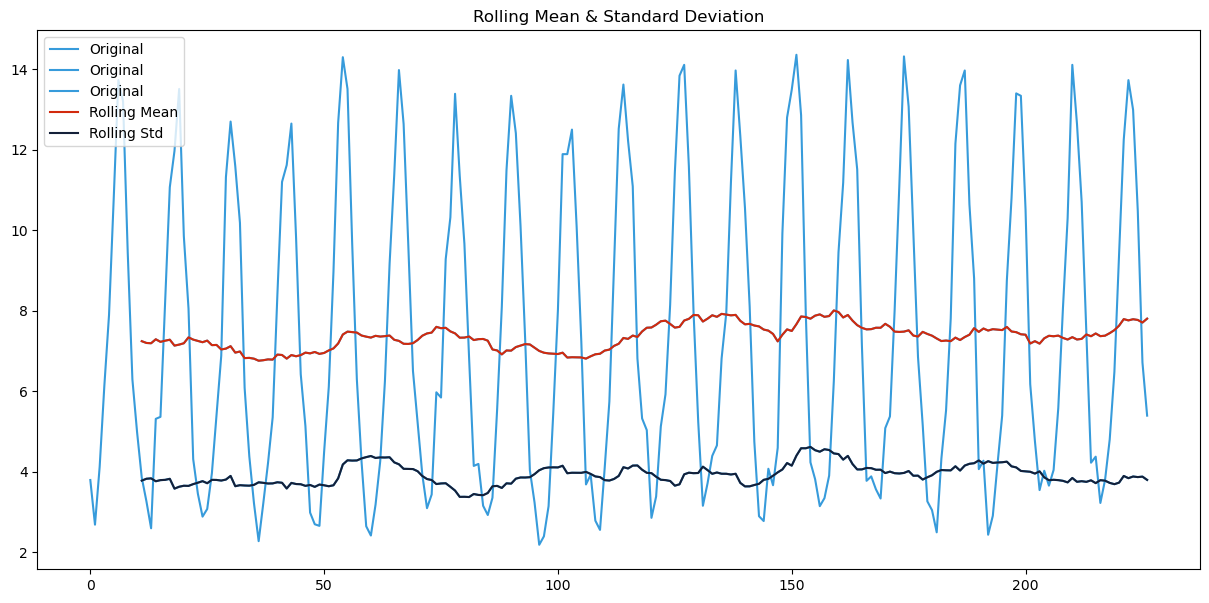

Results of Dickey Fuller Test for Specific Humidity:
Test Statistic                -1.530093e+01
p-value                        4.313806e-28
#Lags Used                     9.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64
Results of Dickey Fuller Test for Specific Humidity:
Test Statistic                  -1.978146
p-value                          0.296237
#Lags Used                      11.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64
5610.541277532282
0.0
Shapiro-Wilk Test for Normality:
{6501: 3.1185658008942296e-09, 6541: 8.182414265776978e-11, 6640: 2.2746835035919295e-08, 6668: 1.197829815588906e-09, 6678: 2.815654475596797e-08, 6687: 1.5005855461937291e-09, 6697: 8.272123076160461e-12, 

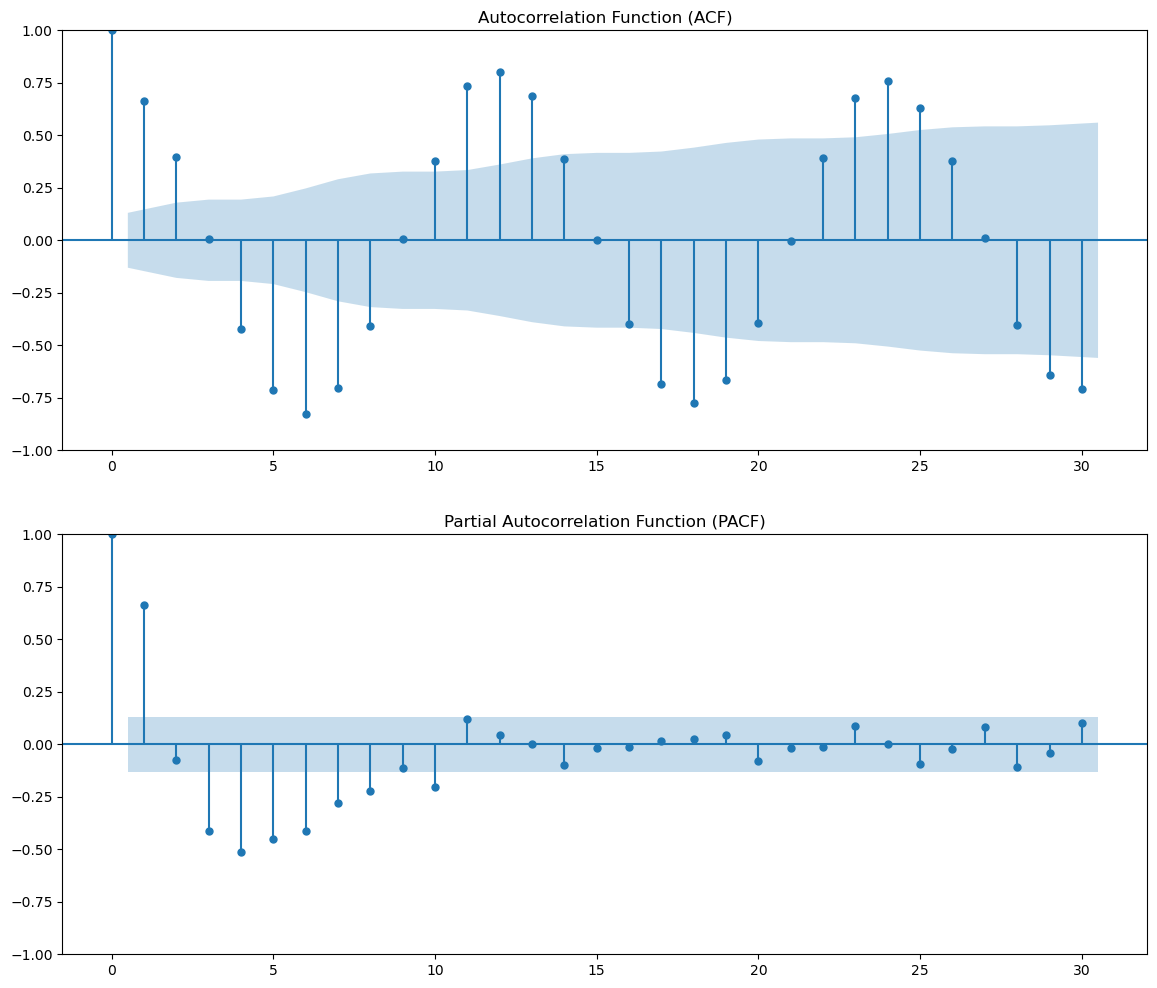

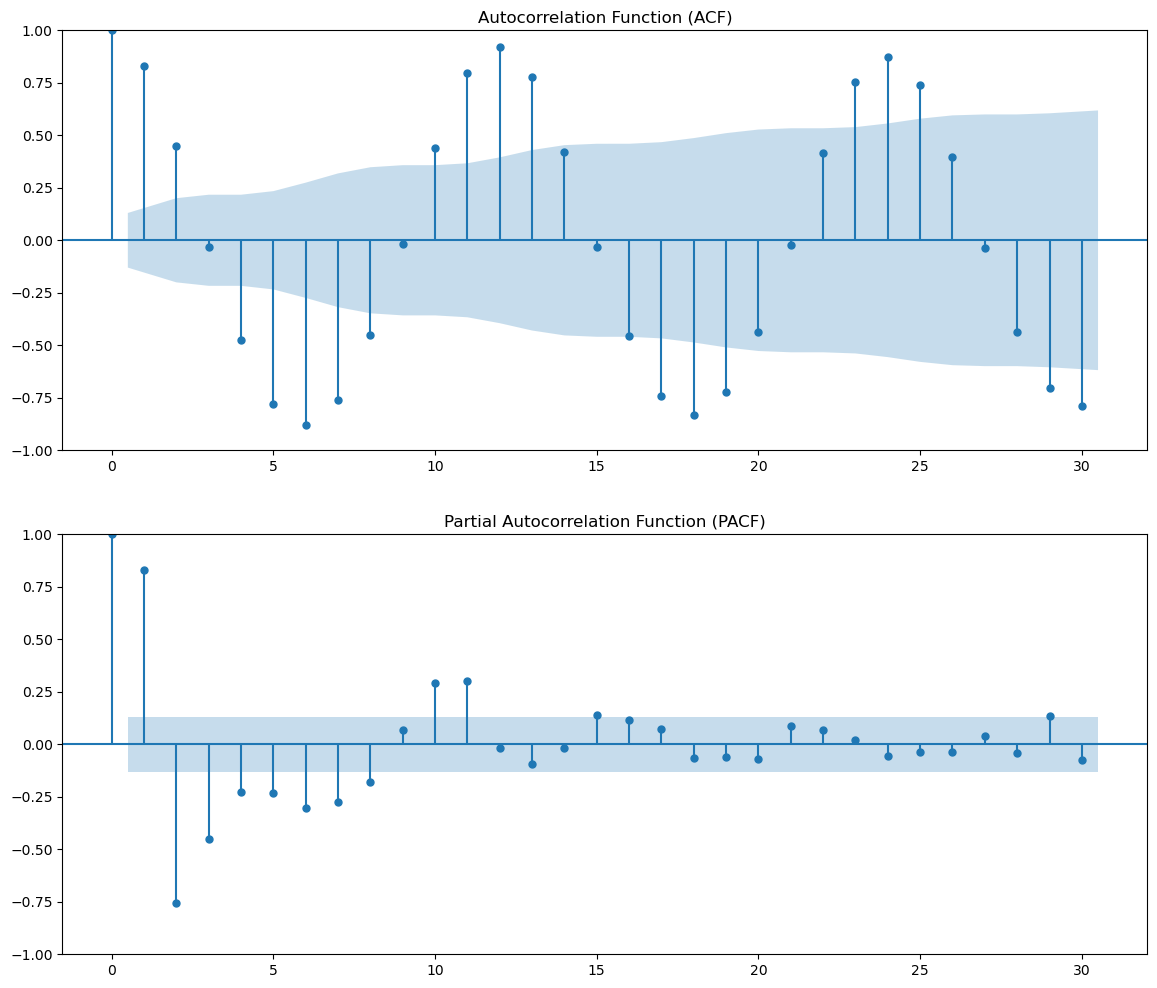

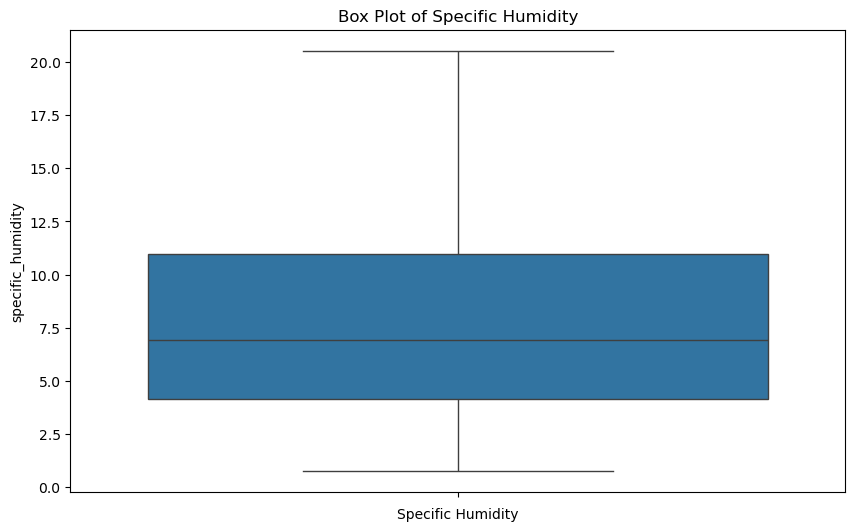

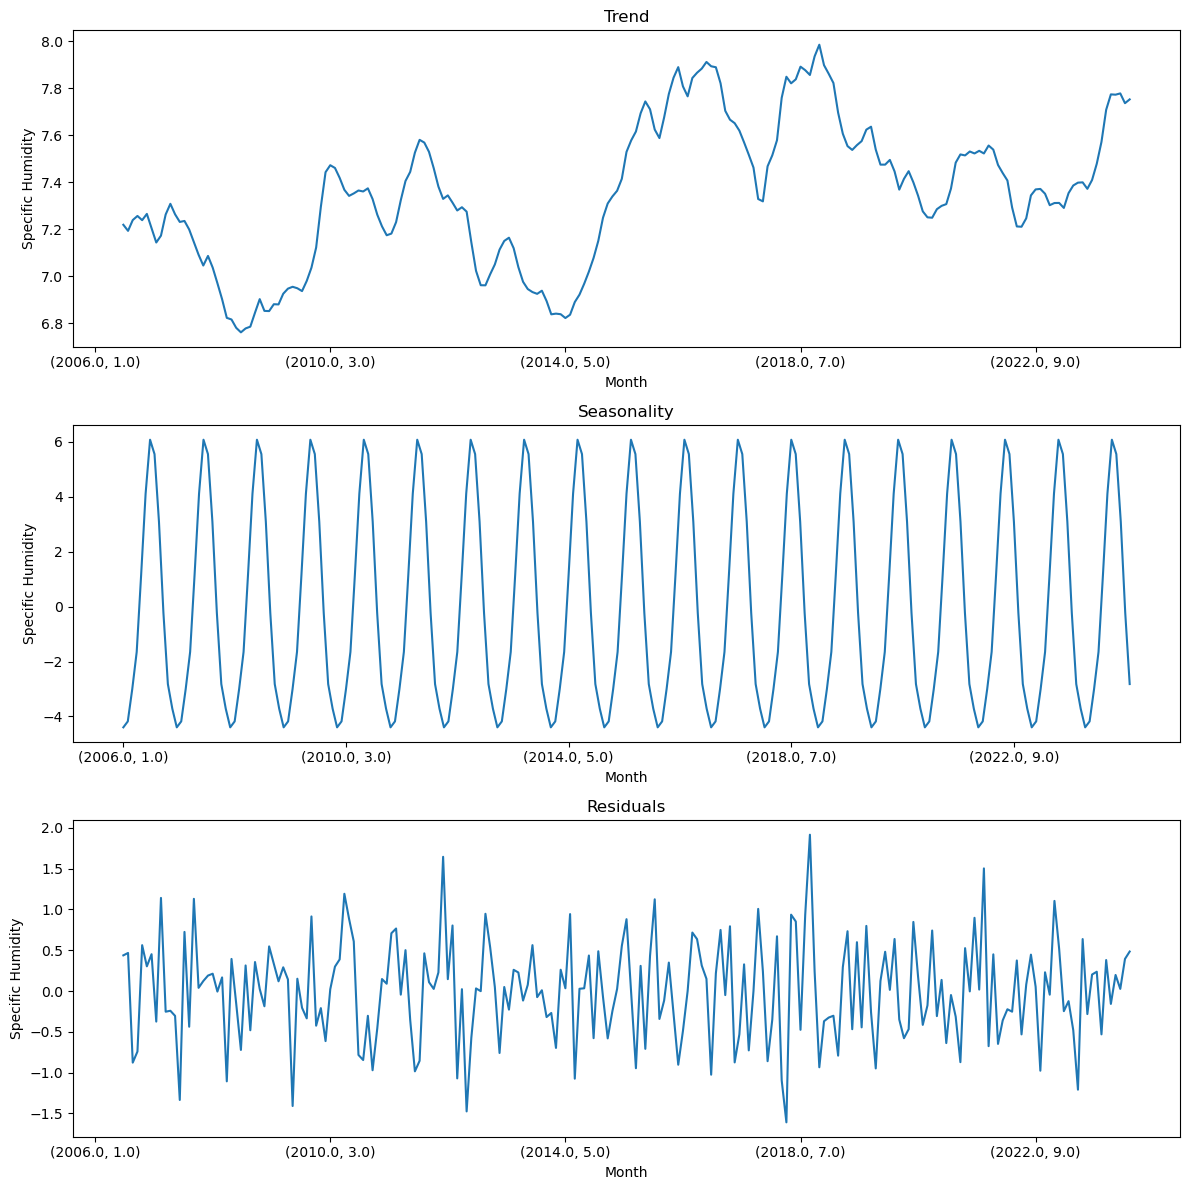

In [41]:
n_batch=1
X = []
y = []
temp = []
sh = []
PC1 = []
PC2 = []
PC3 = []
X_test = []
y_test = []
temp_test = []
sh_test = []
PC1_test = []
PC2_test = []
PC3_test = []
X_val = []
y_val = []
temp_val = []
sh_val = []
PC1_val = []
PC2_val = []
PC3_val = []

train1 = train[0]
test1 = test[0]
validation1 = validation[0]

# Aggregate the original data by getting the median of the weather station specific humidity for each month
y_df = results_df.groupby(['Year', 'Month'])['specific_humidity'].median()
y1 = y_df.values

data = []
for j in range(len(train1)):
    ws_row = []
    for k in range(len(train1[0])):
        Q = train1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (specific humidity)
    data.append(ws_row) # Get single weather station's specific humidity
for j in range(len(test1)):
    ws_row = []
    for k in range(len(test1[0])):
        Q = test1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (specific humidity)
    data.append(ws_row) # Get single weather station's specific humidity
for j in range(len(validation1)):
    ws_row = []
    for k in range(len(validation1[0])):
        Q = validation1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (specific humidity)
    data.append(ws_row) # Get single weather station's specific humidity

# Aggregate the transformed data by getting the median of the weather station specific humidity for each month
y_scaled = []

for j in range(len(data[0])):
    ws_row = [] # holds all 105 weather station's specific humidity for the same time step to get median value
    for k in range(len(data)):
        ws_row.append(data[k][j])
    y_scaled.append(np.median(ws_row))

# Plot data
plot_data(y1, "Specific Humidity")

#Get rolling statistics
rolling_statistics(pd.DataFrame(y1))

# Run Dickey-Fuller test to check if stationary
ADF(y_scaled, "Specific Humidity")
ADF(y1, "Specific Humidity")

#Run Kruskal-Wallis H Test to check if the population median of each weather station is the same
kruskal_stat, kruskal_pval = kruskal(*[results_df[results_df['file_id'] == f]['specific_humidity'] for f in results_df['file_id'].unique()])

print(kruskal_stat)
print(kruskal_pval)
    
#Run Shapiro-Wilk Test for normality
normality_test_results = {}
for ws in results_df['file_id'].unique():
    w, pvalue = shapiro(results_df[results_df['file_id'] == ws]['specific_humidity'])
    normality_test_results[ws] = pvalue
        
# Levene's Test for homogeneity of variances
levene_stat, levene_p = levene(*[results_df[results_df['file_id'] == ws]['specific_humidity'] for ws in results_df['file_id'].unique()])

print("Shapiro-Wilk Test for Normality:")
print(normality_test_results)
print("Levene's Test for Homogeneity of Variances:")
print(levene_stat)
print("Levene p: "+str(levene_p))

# Generate ACF and PACF plots
fig1, axes1 = plt.subplots(2, 1, figsize=(14, 12))

print("Scaled Data:")

# Plot ACF
plot_acf(pd.DataFrame(y_scaled), ax=axes1[0], lags=30, alpha=0.05)
axes1[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(pd.DataFrame(y_scaled), ax=axes1[1], lags=30, alpha=0.05, method='ywm')
axes1[1].set_title('Partial Autocorrelation Function (PACF)')

print("Unscaled Data:")

# Generate ACF and PACF plots
fig2, axes2 = plt.subplots(2, 1, figsize=(14, 12))

# Plot ACF
plot_acf(y_df, ax=axes2[0], lags=30, alpha=0.05)
axes2[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(y_df, ax=axes2[1], lags=30, alpha=0.05, method='ywm')
axes2[1].set_title('Partial Autocorrelation Function (PACF)')

# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(y=results_df['specific_humidity'])
plt.title('Box Plot of Specific Humidity')
plt.xlabel('Specific Humidity')
plt.show()

# Decomposing the time series with an appropriate period based on the data's seasonality
decomposition_filled = seasonal_decompose(y_df, model='additive', period=12) # Monthly seasonality

# Plotting the decomposed components of the time series
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
decomposition_filled.trend.plot(ax=ax1)
ax1.set_title('Trend')
ax1.set_xlabel('Month')
ax1.set_ylabel('Specific Humidity')

decomposition_filled.seasonal.plot(ax=ax2)
ax2.set_title('Seasonality')
ax2.set_xlabel('Month')
ax2.set_ylabel('Specific Humidity')

decomposition_filled.resid.plot(ax=ax3)
ax3.set_title('Residuals')
ax3.set_xlabel('Month')
ax3.set_ylabel('Specific Humidity')

plt.tight_layout()
plt.show()

# Transform data for ARIMA and SARIMAX

for i in range(5):

    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    
    # Transform training data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(train1, n_lag, n_seq)
    X.append(X_row)
    temp.append(temp_row)
    sh.append(sh_row)
    PC1.append(PC1_row)
    PC2.append(PC2_row)
    PC3.append(PC3_row)
    y.append(y_row)
    
    # Transform testing data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(test1, n_lag, n_seq)
    X_test.append(X_row)
    temp_test.append(temp_row)
    sh_test.append(sh_row)
    PC1_test.append(PC1_row)
    PC2_test.append(PC2_row)
    PC3_test.append(PC3_row)
    y_test.append(y_row)

    # Transform validation data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(validation1, n_lag, n_seq)
    X_val.append(X_row)
    temp_val.append(temp_row)
    sh_val.append(sh_row)
    PC1_val.append(PC1_row)
    PC2_val.append(PC2_row)
    PC3_val.append(PC3_row)
    y_val.append(y_row)

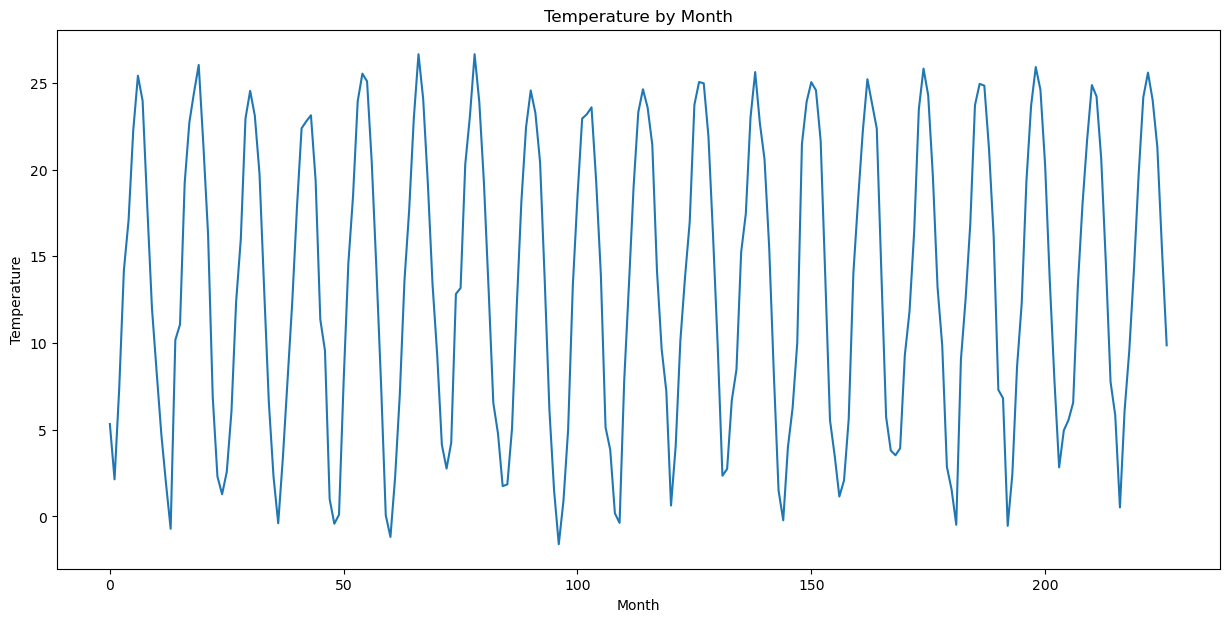

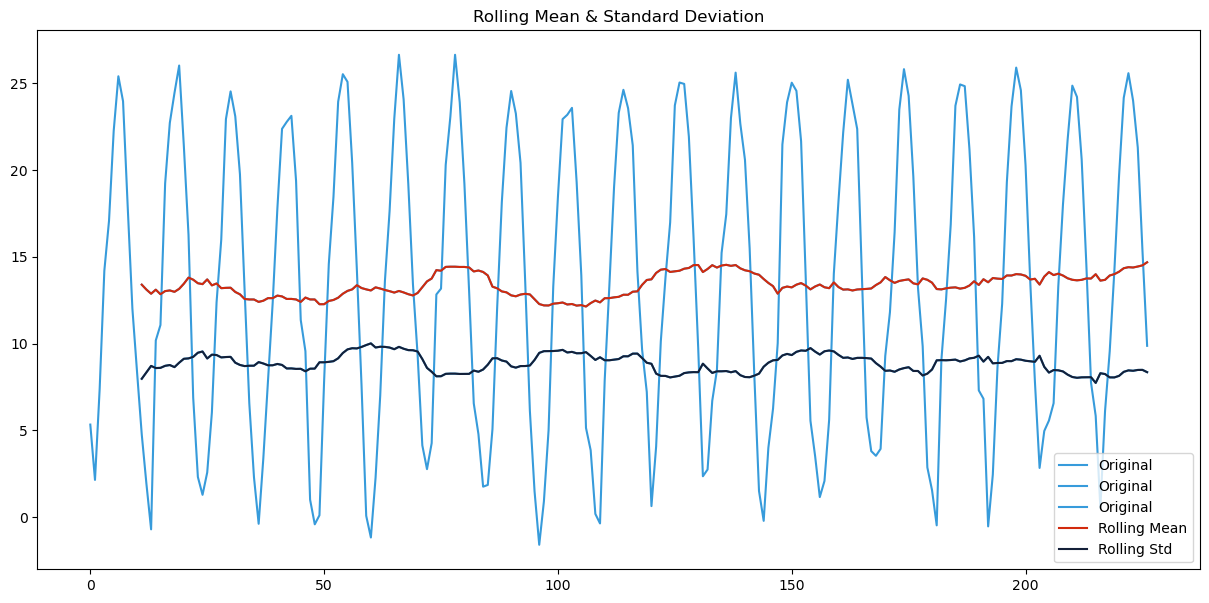

Results of Dickey Fuller Test for Temperature:
Test Statistic                -1.530093e+01
p-value                        4.313806e-28
#Lags Used                     9.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64
Results of Dickey Fuller Test for Temperature:
Test Statistic                  -1.961249
p-value                          0.303818
#Lags Used                      12.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64
5023.1403397674585
0.0
Shapiro-Wilk Test for Normality:
{6501: 2.86869752185945e-08, 6541: 4.065203567402447e-08, 6640: 2.730287140314634e-09, 6668: 1.282499829012734e-08, 6678: 2.6395133105830528e-08, 6687: 1.9321912642995334e-08, 6697: 3.4535783214922218e-09, 6714: 5.4188

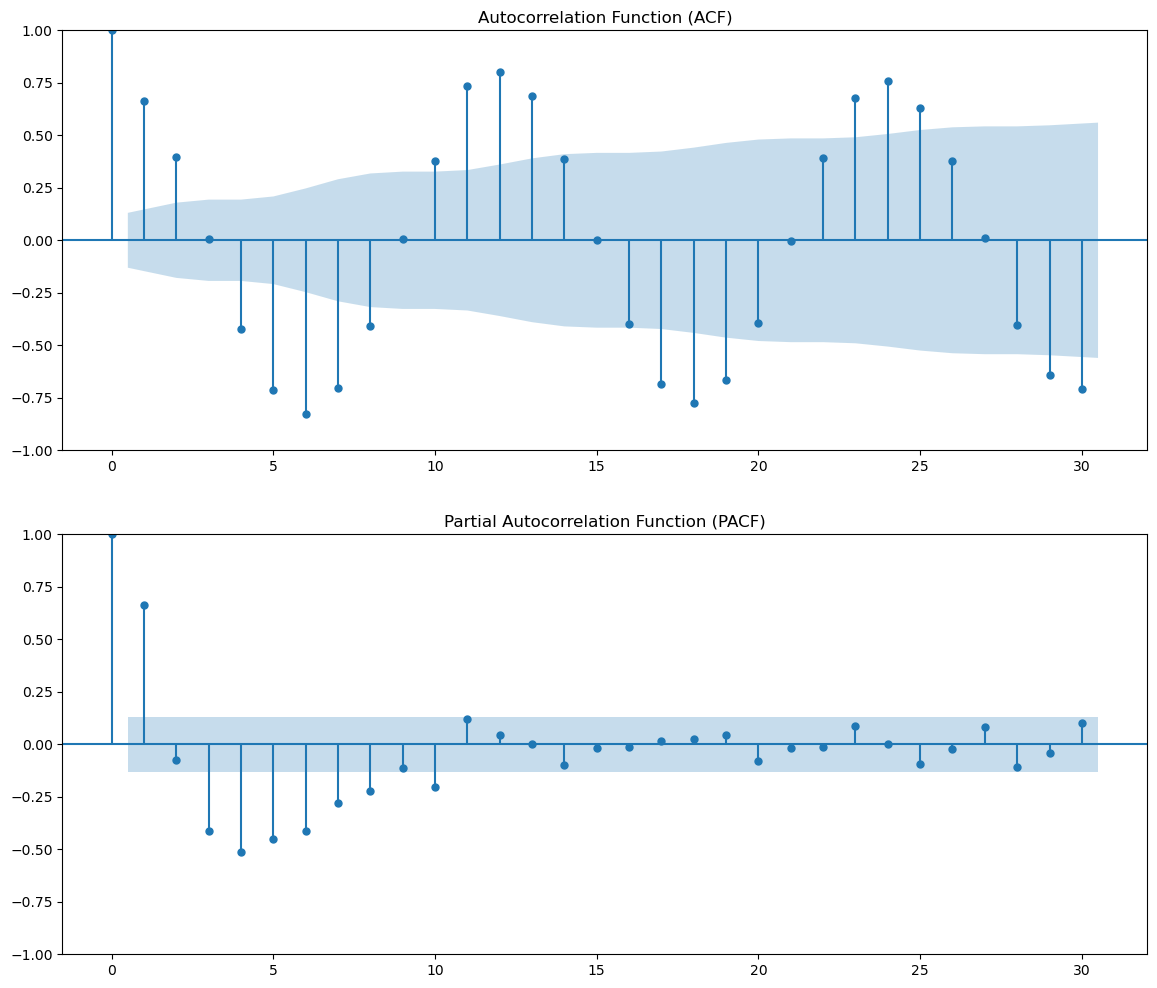

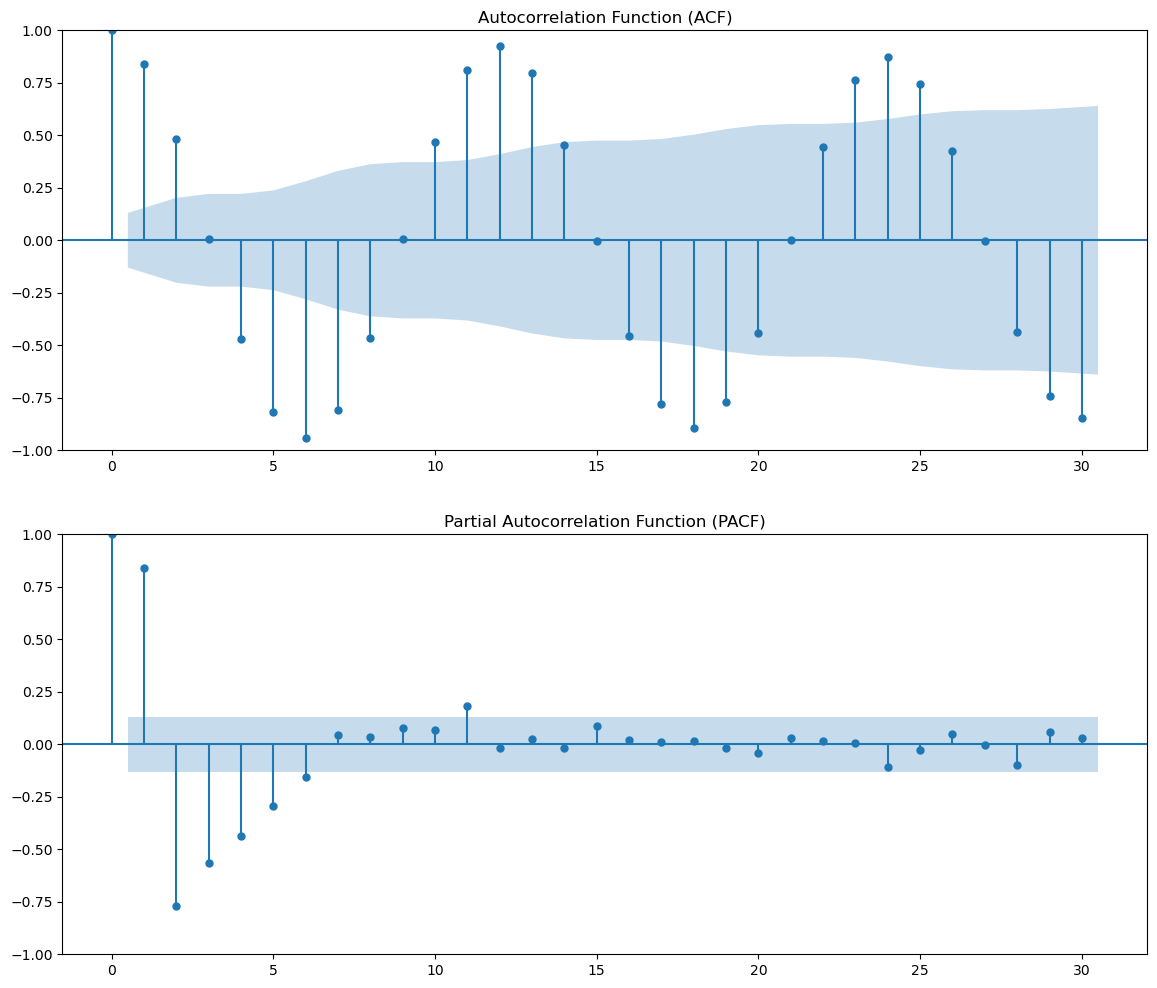

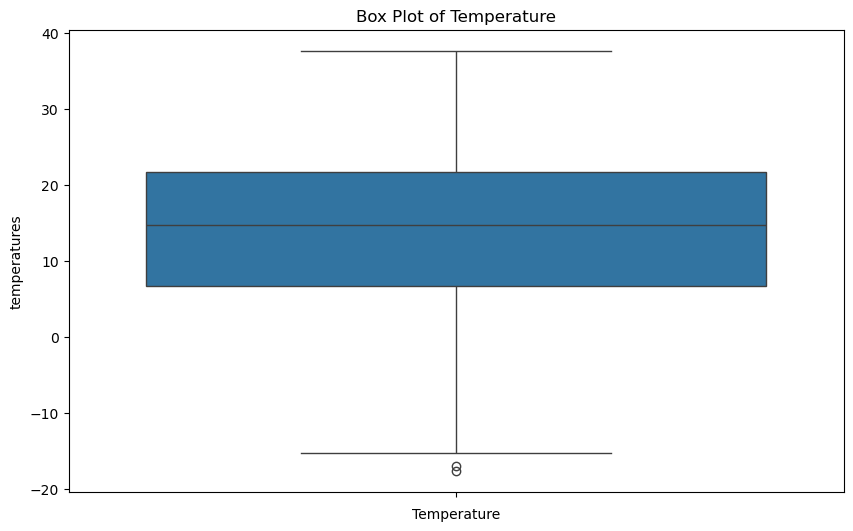

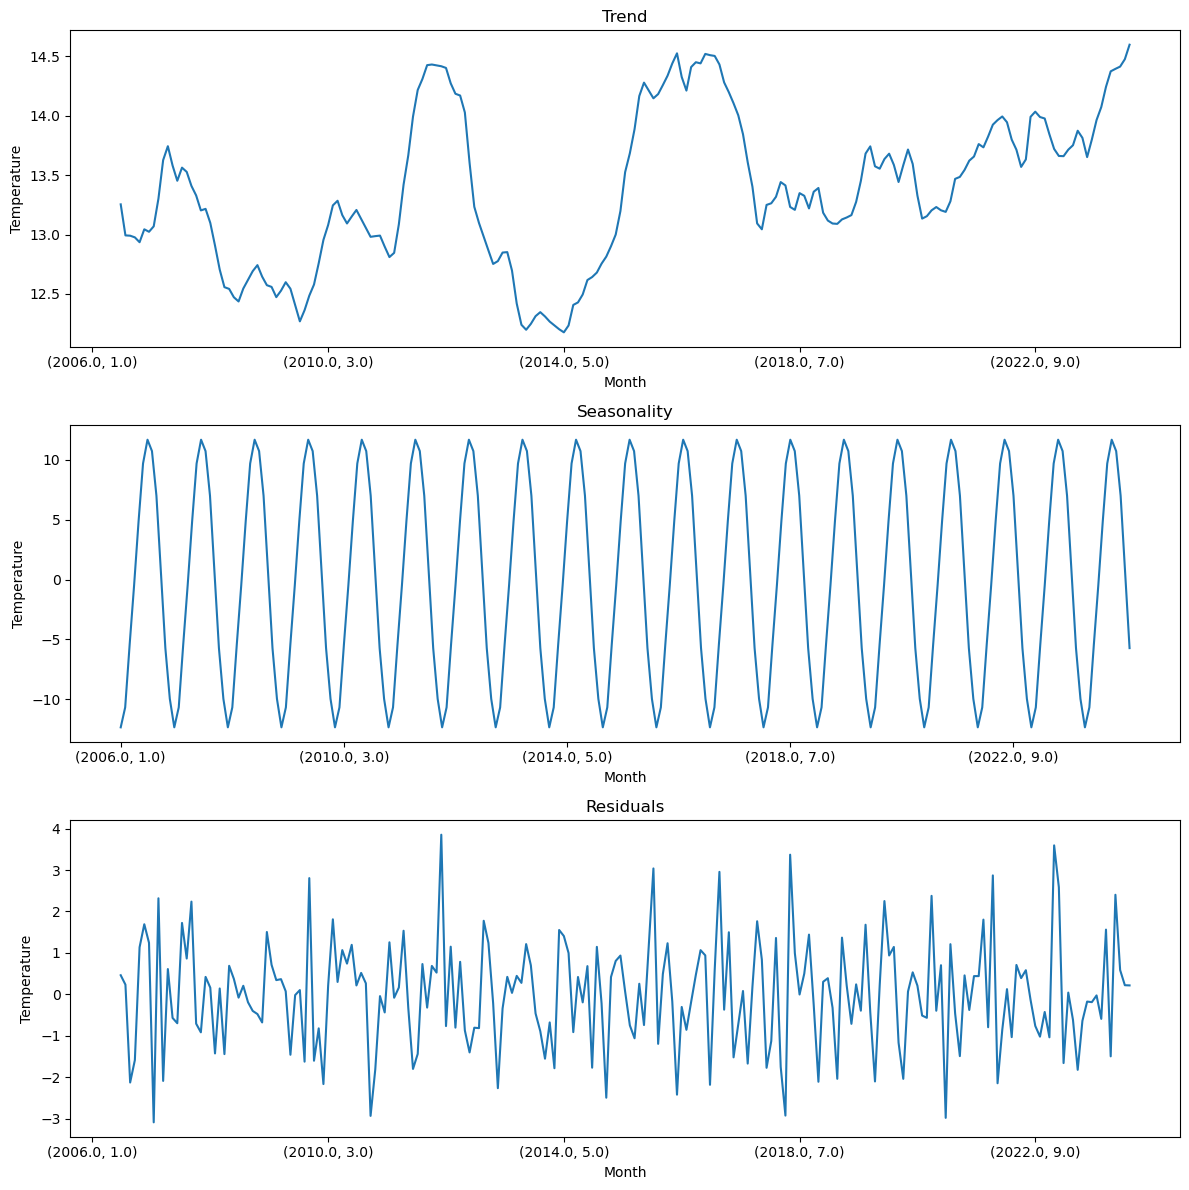

ARIMA Temperature Predictions:
84
10
11
84


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Tue, 27 May 2025   AIC                           -197.154
Time:                        23:50:24   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Tue, 27 May 2025   AIC                           -304.124
Time:                        23:50:24   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(9, 0, 3)   Log Likelihood                 223.463
Date:                Tue, 27 May 2025   AIC                           -418.926
Time:                        23:52:20   BIC                           -374.303
Sample:                             0   HQIC                          -400.832
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4925      0.357      4.183      0.000       0.793       2.192
ar.L1         -0.0756      0.290     -0.261      0.794      -0.643       0.492
ar.L2          0.0253      0.279      0.091      0.9

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Tue, 27 May 2025   AIC                           -528.386
Time:                        23:52:24   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Tue, 27 May 2025   AIC                           -197.154
Time:                        23:52:31   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Weather Station 2 Temperature RMSE value: 0.16733144046030565
Weather Station 2 Specific Humidity RMSE value: 0.09907999102849592


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Tue, 27 May 2025   AIC                           -197.154
Time:                        23:52:38   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Actuals:
[0.26518833535844477, 0.26518833535844477, 0.26518833535844477, 0.26518833535844477, 0.26518833535844477, 0.26518833535844477, 0.26518833535844477, 0.26518833535844477, 0.26518833535844477, 0.26518833535844477]
[0.2422934648581998, 0.2422934648581998, 0.2422934648581998, 0.2422934648581998, 0.2422934648581998, 0.2422934648581998, 0.2422934648581998, 0.2422934648581998, 0.2422934648581998, 0.2422934648581998]
Predicted:
179    0.343376
180    0.401631
181    0.438214
182    0.461187
183    0.475613
184    0.484672
185    0.490361
186    0.493934
187    0.496177
188    0.497586
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 3 Temperature RMSE value: 0.19897898822869248
Weather Station 3 Specific Humidity RMSE value: 0.2517082385800223


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Tue, 27 May 2025   AIC                           -431.468
Time:                        23:53:47   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Tue, 27 May 2025   AIC                           -304.124
Time:                        23:53:47   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(0, 0, 3)   Log Likelihood                 105.552
Date:                Tue, 27 May 2025   AIC                           -201.103
Time:                        23:55:00   BIC                           -185.166
Sample:                             0   HQIC                          -194.641
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5010      0.023     21.636      0.000       0.456       0.546
ma.L1          0.5570      0.069      8.073      0.000       0.422       0.692
ma.L2          0.4280      0.070      6.088      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(9, 0, 2)   Log Likelihood                 263.334
Date:                Tue, 27 May 2025   AIC                           -500.668
Time:                        23:55:03   BIC                           -459.232
Sample:                             0   HQIC                          -483.866
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.8756      0.160     11.695      0.000       1.561       2.190
ar.L1         -0.0742      0.145     -0.512      0.609      -0.358       0.210
ar.L2         -0.1349      0.093     -1.452      0.1

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(7, 0, 1)   Log Likelihood                 202.124
Date:                Tue, 27 May 2025   AIC                           -384.247
Time:                        23:56:31   BIC                           -352.374
Sample:                             0   HQIC                          -371.323
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9081      0.070     12.897      0.000       0.770       1.046
ar.L1          0.2801      0.082      3.418      0.001       0.119       0.441
ar.L2         -0.2005      0.079     -2.539      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(12, 0, 1)   Log Likelihood                 279.076
Date:                Tue, 27 May 2025   AIC                           -528.152
Time:                        23:56:33   BIC                           -480.341
Sample:                             0   HQIC                          -508.765
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0269      2.352      1.287      0.198      -1.583       7.637
ar.L1         -0.4195      0.669     -0.628      0.530      -1.730       0.891
ar.L2         -0.3986      0.311     -1.280      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Tue, 27 May 2025   AIC                           -197.154
Time:                        23:56:44   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Tue, 27 May 2025   AIC                           -304.124
Time:                        23:56:44   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Tue, 27 May 2025   AIC                           -197.154
Time:                        23:56:53   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Tue, 27 May 2025   AIC                           -304.124
Time:                        23:56:54   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Tue, 27 May 2025   AIC                           -197.154
Time:                        23:57:05   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Tue, 27 May 2025   AIC                           -304.124
Time:                        23:57:05   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Tue, 27 May 2025   AIC                           -197.154
Time:                        23:57:15   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Tue, 27 May 2025   AIC                           -304.124
Time:                        23:57:15   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Tue, 27 May 2025   AIC                           -197.154
Time:                        23:57:25   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Tue, 27 May 2025   AIC                           -304.124
Time:                        23:57:25   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Tue, 27 May 2025   AIC                           -197.154
Time:                        23:57:35   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Tue, 27 May 2025   AIC                           -304.124
Time:                        23:57:35   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Tue, 27 May 2025   AIC                           -197.154
Time:                        23:57:44   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.3177399756986634, 0.3177399756986634, 0.3177399756986634, 0.3177399756986634, 0.3177399756986634, 0.3177399756986634, 0.3177399756986634, 0.3177399756986634, 0.3177399756986634, 0.3177399756986634]
[0.35881627620221956, 0.35881627620221956, 0.35881627620221956, 0.35881627620221956, 0.35881627620221956, 0.35881627620221956, 0.35881627620221956, 0.35881627620221956, 0.35881627620221956, 0.35881627620221956]
Predicted:
179    0.343376
180    0.401631
181    0.438214
182    0.461187
183    0.475613
184    0.484672
185    0.490361
186    0.493934
187    0.496177
188    0.497586
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 13 Temperature RMSE value: 0.14852700162942184
Weather Station 13 Specific Humidity RMSE value: 0.1353356194210743


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Tue, 27 May 2025   AIC                           -431.468
Time:                        23:59:14   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.3071081409477522, 0.3071081409477522, 0.3071081409477522, 0.3071081409477522, 0.3071081409477522, 0.3071081409477522, 0.3071081409477522, 0.3071081409477522, 0.3071081409477522, 0.3071081409477522]
[0.33477188655980283, 0.33477188655980283, 0.33477188655980283, 0.33477188655980283, 0.33477188655980283, 0.33477188655980283, 0.33477188655980283, 0.33477188655980283, 0.33477188655980283, 0.33477188655980283]
Predicted:
179    0.493915
180    0.582262
181    0.654119
182    0.698511
183    0.725547
184    0.663610
185    0.559632
186    0.431280
187    0.334559
188    0.286751
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 14 Temperature RMSE value: 0.27690407826022234
Weather Station 14 Specific Humidity RMSE value: 0.15933104133103262


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        00:00:29   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.31257594167679226, 0.31257594167679226, 0.31257594167679226, 0.31257594167679226, 0.31257594167679226, 0.31257594167679226, 0.31257594167679226, 0.31257594167679226, 0.31257594167679226, 0.31257594167679226]
[0.341553637484587, 0.341553637484587, 0.341553637484587, 0.341553637484587, 0.341553637484587, 0.341553637484587, 0.341553637484587, 0.341553637484587, 0.341553637484587, 0.341553637484587]
Predicted:
179    0.493915
180    0.582262
181    0.654119
182    0.698511
183    0.725547
184    0.663610
185    0.559632
186    0.431280
187    0.334559
188    0.286751
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 15 Temperature RMSE value: 0.2722607991423768
Weather Station 15 Specific Humidity RMSE value: 0.15256154062887725


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        00:02:34   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 273.847
Date:                Wed, 28 May 2025   AIC                           -521.694
Time:                        00:02:37   BIC                           -480.258
Sample:                             0   HQIC                          -504.892
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.6862      0.251     10.703      0.000       2.194       3.178
ar.L1         -0.2660      0.128     -2.071      0.038      -0.518      -0.014
ar.L2         -0.3198      0.058     -5.499      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        00:03:52   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:03:52   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        00:05:06   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:05:06   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(9, 0, 1)   Log Likelihood                 221.303
Date:                Wed, 28 May 2025   AIC                           -418.605
Time:                        00:06:15   BIC                           -380.356
Sample:                             0   HQIC                          -403.095
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7223      0.194      8.896      0.000       1.343       2.102
ar.L1          0.0354      0.101      0.349      0.727      -0.163       0.234
ar.L2         -0.3705      0.067     -5.550      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 191.175
Date:                Wed, 28 May 2025   AIC                           -372.349
Time:                        00:06:16   BIC                           -356.412
Sample:                             0   HQIC                          -365.887
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1693      0.018      9.585      0.000       0.135       0.204
ar.L1          1.4964      0.048     31.093      0.000       1.402       1.591
ar.L2         -0.8337      0.047    -17.929      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(0, 0, 7)   Log Likelihood                 132.621
Date:                Wed, 28 May 2025   AIC                           -247.241
Time:                        00:07:57   BIC                           -218.555
Sample:                             0   HQIC                          -235.609
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5033      0.002    291.232      0.000       0.500       0.507
ma.L1          0.3608      0.175      2.066      0.039       0.019       0.703
ma.L2          0.1509      0.247      0.611      0.5

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(12, 0, 1)   Log Likelihood                 279.076
Date:                Wed, 28 May 2025   AIC                           -528.152
Time:                        00:07:59   BIC                           -480.341
Sample:                             0   HQIC                          -508.765
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0269      2.352      1.287      0.198      -1.583       7.637
ar.L1         -0.4195      0.669     -0.628      0.530      -1.730       0.891
ar.L2         -0.3986      0.311     -1.280      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:08:07   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.29070473876063185, 0.29070473876063185, 0.29070473876063185, 0.29070473876063185, 0.29070473876063185, 0.29070473876063185, 0.29070473876063185, 0.29070473876063185, 0.29070473876063185, 0.29070473876063185]
[0.30332922318125777, 0.30332922318125777, 0.30332922318125777, 0.30332922318125777, 0.30332922318125777, 0.30332922318125777, 0.30332922318125777, 0.30332922318125777, 0.30332922318125777, 0.30332922318125777]
Predicted:
179    0.343376
180    0.401631
181    0.438214
182    0.461187
183    0.475613
184    0.484672
185    0.490361
186    0.493934
187    0.496177
188    0.497586
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 21 Temperature RMSE value: 0.17432719204261807
Weather Station 21 Specific Humidity RMSE value: 0.1907282810318124


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:08:16   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.28432563791008514, 0.28432563791008514, 0.28432563791008514, 0.28432563791008514, 0.28432563791008514, 0.28432563791008514, 0.28432563791008514, 0.28432563791008514, 0.28432563791008514, 0.28432563791008514]
[0.3341553637484588, 0.3341553637484588, 0.3341553637484588, 0.3341553637484588, 0.3341553637484588, 0.3341553637484588, 0.3341553637484588, 0.3341553637484588, 0.3341553637484588, 0.3341553637484588]
Predicted:
179    0.343376
180    0.401631
181    0.438214
182    0.461187
183    0.475613
184    0.484672
185    0.490361
186    0.493934
187    0.496177
188    0.497586
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 22 Temperature RMSE value: 0.18046760947672036
Weather Station 22 Specific Humidity RMSE value: 0.15994650195108423


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:08:24   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:08:25   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(6, 0, 1)   Log Likelihood                 201.754
Date:                Wed, 28 May 2025   AIC                           -385.508
Time:                        00:09:00   BIC                           -356.822
Sample:                             0   HQIC                          -373.876
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6579      0.045     14.680      0.000       0.570       0.746
ar.L1          0.4003      0.076      5.298      0.000       0.252       0.548
ar.L2         -0.0325      0.081     -0.402      0.6

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:09:00   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:09:08   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:09:09   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        00:11:21   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Wed, 28 May 2025   AIC                           -528.386
Time:                        00:11:25   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:11:32   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:11:32   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:11:41   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:11:41   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        00:12:45   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:12:45   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        00:13:57   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.30042527339003644, 0.30042527339003644, 0.30042527339003644, 0.30042527339003644, 0.30042527339003644, 0.30042527339003644, 0.30042527339003644, 0.30042527339003644, 0.30042527339003644, 0.30042527339003644]
[0.3612823674475957, 0.3612823674475957, 0.3612823674475957, 0.3612823674475957, 0.3612823674475957, 0.3612823674475957, 0.3612823674475957, 0.3612823674475957, 0.3612823674475957, 0.3612823674475957]
Predicted:
179    0.493915
180    0.582262
181    0.654119
182    0.698511
183    0.725547
184    0.663610
185    0.559632
186    0.431280
187    0.334559
188    0.286751
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 30 Temperature RMSE value: 0.28261925951885025
Weather Station 30 Specific Humidity RMSE value: 0.13287555151415684


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        00:14:54   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:14:54   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(12, 0, 1)   Log Likelihood                 230.008
Date:                Wed, 28 May 2025   AIC                           -430.016
Time:                        00:16:08   BIC                           -382.205
Sample:                             0   HQIC                          -410.629
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.9705     27.827      0.143      0.887     -50.570      58.511
ar.L1         -0.6458      7.387     -0.087      0.930     -15.125      13.833
ar.L2         -0.6823      4.445     -0.153      0.8

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        00:17:08   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 33 Temperature RMSE value: 0.2918524836022401
Weather Station 33 Specific Humidity RMSE value: 0.12549676641600802


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:17:15   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.3137910085054678, 0.3137910085054678, 0.3137910085054678, 0.3137910085054678, 0.3137910085054678, 0.3137910085054678, 0.3137910085054678, 0.3137910085054678, 0.3137910085054678, 0.3137910085054678]
[0.34093711467324295, 0.34093711467324295, 0.34093711467324295, 0.34093711467324295, 0.34093711467324295, 0.34093711467324295, 0.34093711467324295, 0.34093711467324295, 0.34093711467324295, 0.34093711467324295]
Predicted:
179    0.343376
180    0.401631
181    0.438214
182    0.461187
183    0.475613
184    0.484672
185    0.490361
186    0.493934
187    0.496177
188    0.497586
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 34 Temperature RMSE value: 0.15226884446975172
Weather Station 34 Specific Humidity RMSE value: 0.15317690500046527


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:18:14   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(12, 0, 1)   Log Likelihood                 279.076
Date:                Wed, 28 May 2025   AIC                           -528.152
Time:                        00:18:16   BIC                           -480.341
Sample:                             0   HQIC                          -508.765
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0269      2.352      1.287      0.198      -1.583       7.637
ar.L1         -0.4195      0.669     -0.628      0.530      -1.730       0.891
ar.L2         -0.3986      0.311     -1.280      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:18:23   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.28462940461725394, 0.28462940461725394, 0.28462940461725394, 0.28462940461725394, 0.28462940461725394, 0.28462940461725394, 0.28462940461725394, 0.28462940461725394, 0.28462940461725394, 0.28462940461725394]
[0.40258939580764497, 0.40258939580764497, 0.40258939580764497, 0.40258939580764497, 0.40258939580764497, 0.40258939580764497, 0.40258939580764497, 0.40258939580764497, 0.40258939580764497, 0.40258939580764497]
Predicted:
179    0.343376
180    0.401631
181    0.438214
182    0.461187
183    0.475613
184    0.484672
185    0.490361
186    0.493934
187    0.496177
188    0.497586
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 36 Temperature RMSE value: 0.1801748325695938
Weather Station 36 Specific Humidity RMSE value: 0.09171751910299093


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:18:32   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:18:32   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:19:23   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:20:26   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Wed, 28 May 2025   AIC                           -528.386
Time:                        00:20:30   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:21:28   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Wed, 28 May 2025   AIC                           -528.386
Time:                        00:21:30   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:21:35   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(7, 0, 2)   Log Likelihood                 209.340
Date:                Wed, 28 May 2025   AIC                           -396.679
Time:                        00:22:20   BIC                           -361.618
Sample:                             0   HQIC                          -382.462
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1402      0.154      7.392      0.000       0.838       1.443
ar.L1         -0.2618      0.270     -0.968      0.333      -0.792       0.268
ar.L2          0.2485      0.178      1.398      0.1

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.33019441069258815, 0.33019441069258815, 0.33019441069258815, 0.33019441069258815, 0.33019441069258815, 0.33019441069258815, 0.33019441069258815, 0.33019441069258815, 0.33019441069258815, 0.33019441069258815]
[0.45191122071516654, 0.45191122071516654, 0.45191122071516654, 0.45191122071516654, 0.45191122071516654, 0.45191122071516654, 0.45191122071516654, 0.45191122071516654, 0.45191122071516654, 0.45191122071516654]
Predicted:
179    0.465321
180    0.575224
181    0.668507
182    0.731748
183    0.696925
184    0.661747
185    0.578066
186    0.429479
187    0.349832
188    0.285833
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 42 Temperature RMSE value: 0.25924286148030845
Weather Station 42 Specific Humidity RMSE value: 0.04294997096372429


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 2)   Log Likelihood                 219.457
Date:                Wed, 28 May 2025   AIC                           -410.913
Time:                        00:24:55   BIC                           -366.290
Sample:                             0   HQIC                          -392.819
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0032      0.544      5.516      0.000       1.936       4.070
ar.L1         -0.5528      0.319     -1.733      0.083      -1.178       0.072
ar.L2         -0.5324      0.126     -4.226      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 2)   Log Likelihood                 278.587
Date:                Wed, 28 May 2025   AIC                           -527.175
Time:                        00:25:00   BIC                           -479.364
Sample:                             0   HQIC                          -507.788
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.5190      1.486      2.368      0.018       0.606       6.432
ar.L1         -0.4487      0.659     -0.681      0.496      -1.740       0.843
ar.L2         -0.5007      0.161     -3.109      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        00:27:33   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Wed, 28 May 2025   AIC                           -528.386
Time:                        00:27:38   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        00:29:02   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 146.206
Date:                Wed, 28 May 2025   AIC                           -286.412
Time:                        00:29:02   BIC                           -276.850
Sample:                             0   HQIC                          -282.535
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5015      0.012     42.357      0.000       0.478       0.525
ma.L1          0.4618      0.061      7.546      0.000       0.342       0.582
sigma2         0.0114      0.001      9.477      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:29:11   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


179    0.501853
180    0.501853
181    0.501853
182    0.501853
183    0.501853
184    0.501853
185    0.501853
186    0.501853
187    0.501853
188    0.501853
dtype: float64
Weather Station 46 Temperature RMSE value: 0.05105108645842988
Weather Station 46 Specific Humidity RMSE value: 0.020965219838255278


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        00:31:17   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(12, 0, 1)   Log Likelihood                 279.076
Date:                Wed, 28 May 2025   AIC                           -528.152
Time:                        00:31:20   BIC                           -480.341
Sample:                             0   HQIC                          -508.765
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0269      2.352      1.287      0.198      -1.583       7.637
ar.L1         -0.4195      0.669     -0.628      0.530      -1.730       0.891
ar.L2         -0.3986      0.311     -1.280      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:31:28   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:31:29   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        00:32:36   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.2961725394896719, 0.2961725394896719, 0.2961725394896719, 0.2961725394896719, 0.2961725394896719, 0.2961725394896719, 0.2961725394896719, 0.2961725394896719, 0.2961725394896719, 0.2961725394896719]
[0.3877928483353885, 0.3877928483353885, 0.3877928483353885, 0.3877928483353885, 0.3877928483353885, 0.3877928483353885, 0.3877928483353885, 0.3877928483353885, 0.3877928483353885, 0.3877928483353885]
Predicted:
179    0.480603
180    0.609950
181    0.629332
182    0.708835
183    0.732368
184    0.650574
185    0.571243
186    0.421928
187    0.335102
188    0.307703
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 49 Temperature RMSE value: 0.28683625731768064
Weather Station 49 Specific Humidity RMSE value: 0.10644742759952223


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(9, 0, 1)   Log Likelihood                 221.303
Date:                Wed, 28 May 2025   AIC                           -418.605
Time:                        00:33:48   BIC                           -380.356
Sample:                             0   HQIC                          -403.095
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7223      0.194      8.896      0.000       1.343       2.102
ar.L1          0.0354      0.101      0.349      0.727      -0.163       0.234
ar.L2         -0.3705      0.067     -5.550      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:33:49   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        00:34:59   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:34:59   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        00:37:07   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(12, 0, 1)   Log Likelihood                 279.076
Date:                Wed, 28 May 2025   AIC                           -528.152
Time:                        00:37:09   BIC                           -480.341
Sample:                             0   HQIC                          -508.765
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0269      2.352      1.287      0.198      -1.583       7.637
ar.L1         -0.4195      0.669     -0.628      0.530      -1.730       0.891
ar.L2         -0.3986      0.311     -1.280      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        00:38:23   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:38:31   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:38:31   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:38:39   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:38:40   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:38:48   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.30072904009720536, 0.30072904009720536, 0.30072904009720536, 0.30072904009720536, 0.30072904009720536, 0.30072904009720536, 0.30072904009720536, 0.30072904009720536, 0.30072904009720536, 0.30072904009720536]
[0.39827373612823685, 0.39827373612823685, 0.39827373612823685, 0.39827373612823685, 0.39827373612823685, 0.39827373612823685, 0.39827373612823685, 0.39827373612823685, 0.39827373612823685, 0.39827373612823685]
Predicted:
179    0.343376
180    0.401631
181    0.438214
182    0.461187
183    0.475613
184    0.484672
185    0.490361
186    0.493934
187    0.496177
188    0.497586
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 56 Temperature RMSE value: 0.1647146223411732
Weather Station 56 Specific Humidity RMSE value: 0.09601162548930561


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:38:54   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.2952612393681653, 0.2952612393681653, 0.2952612393681653, 0.2952612393681653, 0.2952612393681653, 0.2952612393681653, 0.2952612393681653, 0.2952612393681653, 0.2952612393681653, 0.2952612393681653]
[0.4069050554870531, 0.4069050554870531, 0.4069050554870531, 0.4069050554870531, 0.4069050554870531, 0.4069050554870531, 0.4069050554870531, 0.4069050554870531, 0.4069050554870531, 0.4069050554870531]
Predicted:
179    0.343376
180    0.401631
181    0.438214
182    0.461187
183    0.475613
184    0.484672
185    0.490361
186    0.493934
187    0.496177
188    0.497586
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 57 Temperature RMSE value: 0.16995194480338427
Weather Station 57 Specific Humidity RMSE value: 0.08742553533523983


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        00:39:53   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:39:54   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:40:04   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:40:04   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:40:13   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.2736938031591738, 0.2736938031591738, 0.2736938031591738, 0.2736938031591738, 0.2736938031591738, 0.2736938031591738, 0.2736938031591738, 0.2736938031591738, 0.2736938031591738, 0.2736938031591738]
[0.38717632552404446, 0.38717632552404446, 0.38717632552404446, 0.38717632552404446, 0.38717632552404446, 0.38717632552404446, 0.38717632552404446, 0.38717632552404446, 0.38717632552404446, 0.38717632552404446]
Predicted:
179    0.343376
180    0.401631
181    0.438214
182    0.461187
183    0.475613
184    0.484672
185    0.490361
186    0.493934
187    0.496177
188    0.497586
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 60 Temperature RMSE value: 0.1907364564903073
Weather Station 60 Specific Humidity RMSE value: 0.10706157262288087


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        00:41:18   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.29829890643985424, 0.29829890643985424, 0.29829890643985424, 0.29829890643985424, 0.29829890643985424, 0.29829890643985424, 0.29829890643985424, 0.29829890643985424, 0.29829890643985424, 0.29829890643985424]
[0.3933415536374847, 0.3933415536374847, 0.3933415536374847, 0.3933415536374847, 0.3933415536374847, 0.3933415536374847, 0.3933415536374847, 0.3933415536374847, 0.3933415536374847, 0.3933415536374847]
Predicted:
179    0.480603
180    0.609950
181    0.629332
182    0.708835
183    0.732368
184    0.650574
185    0.571243
186    0.421928
187    0.335102
188    0.307703
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 61 Temperature RMSE value: 0.2849953813333265
Weather Station 61 Specific Humidity RMSE value: 0.10092142719520718


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        00:42:21   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        00:42:21   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        00:43:44   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 63 Temperature RMSE value: 0.3203049512240064
Weather Station 63 Specific Humidity RMSE value: 0.10214921455478916


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(12, 0, 1)   Log Likelihood                 230.008
Date:                Wed, 28 May 2025   AIC                           -430.016
Time:                        00:45:36   BIC                           -382.205
Sample:                             0   HQIC                          -410.629
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.9705     27.827      0.143      0.887     -50.570      58.511
ar.L1         -0.6458      7.387     -0.087      0.930     -15.125      13.833
ar.L2         -0.6823      4.445     -0.153      0.8

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Wed, 28 May 2025   AIC                           -528.386
Time:                        00:45:40   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        00:47:07   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Wed, 28 May 2025   AIC                           -528.386
Time:                        00:47:11   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(12, 0, 1)   Log Likelihood                 230.008
Date:                Wed, 28 May 2025   AIC                           -430.016
Time:                        00:49:07   BIC                           -382.205
Sample:                             0   HQIC                          -410.629
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.9705     27.827      0.143      0.887     -50.570      58.511
ar.L1         -0.6458      7.387     -0.087      0.930     -15.125      13.833
ar.L2         -0.6823      4.445     -0.153      0.8

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(12, 0, 1)   Log Likelihood                 279.076
Date:                Wed, 28 May 2025   AIC                           -528.152
Time:                        00:49:09   BIC                           -480.341
Sample:                             0   HQIC                          -508.765
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0269      2.352      1.287      0.198      -1.583       7.637
ar.L1         -0.4195      0.669     -0.628      0.530      -1.730       0.891
ar.L2         -0.3986      0.311     -1.280      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        00:51:02   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Wed, 28 May 2025   AIC                           -528.386
Time:                        00:51:07   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(7, 0, 1)   Log Likelihood                 202.124
Date:                Wed, 28 May 2025   AIC                           -384.247
Time:                        00:52:37   BIC                           -352.374
Sample:                             0   HQIC                          -371.323
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9081      0.070     12.897      0.000       0.770       1.046
ar.L1          0.2801      0.082      3.418      0.001       0.119       0.441
ar.L2         -0.2005      0.079     -2.539      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Wed, 28 May 2025   AIC                           -528.386
Time:                        00:52:41   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        00:55:22   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Wed, 28 May 2025   AIC                           -528.386
Time:                        00:55:27   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        00:56:58   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Wed, 28 May 2025   AIC                           -528.386
Time:                        00:57:02   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        00:58:15   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 71 Temperature RMSE value: 0.3211205076518269
Weather Station 71 Specific Humidity RMSE value: 0.10706157262288087


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        01:00:13   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Wed, 28 May 2025   AIC                           -528.386
Time:                        01:00:18   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        01:01:12   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.27733900364520053, 0.27733900364520053, 0.27733900364520053, 0.27733900364520053, 0.27733900364520053, 0.27733900364520053, 0.27733900364520053, 0.27733900364520053, 0.27733900364520053, 0.27733900364520053]
[0.404438964241677, 0.404438964241677, 0.404438964241677, 0.404438964241677, 0.404438964241677, 0.404438964241677, 0.404438964241677, 0.404438964241677, 0.404438964241677, 0.404438964241677]
Predicted:
179    0.480603
180    0.609950
181    0.629332
182    0.708835
183    0.732368
184    0.650574
185    0.571243
186    0.421928
187    0.335102
188    0.307703
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 73 Temperature RMSE value: 0.3033042139151296
Weather Station 73 Specific Humidity RMSE value: 0.08987781984126292


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        01:02:48   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(6, 0, 1)   Log Likelihood                 219.439
Date:                Wed, 28 May 2025   AIC                           -420.878
Time:                        01:02:49   BIC                           -392.192
Sample:                             0   HQIC                          -409.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4589      0.039     11.753      0.000       0.382       0.535
ar.L1          0.8409      0.077     10.939      0.000       0.690       0.992
ar.L2          0.0278      0.095      0.294      0.7

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        01:04:47   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Wed, 28 May 2025   AIC                           -528.386
Time:                        01:04:49   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(7, 0, 1)   Log Likelihood                 202.124
Date:                Wed, 28 May 2025   AIC                           -384.247
Time:                        01:05:33   BIC                           -352.374
Sample:                             0   HQIC                          -371.323
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9081      0.070     12.897      0.000       0.770       1.046
ar.L1          0.2801      0.082      3.418      0.001       0.119       0.441
ar.L2         -0.2005      0.079     -2.539      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        01:05:33   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        01:06:40   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.4149453219927096, 0.4149453219927096, 0.4149453219927096, 0.4149453219927096, 0.4149453219927096, 0.4149453219927096, 0.4149453219927096, 0.4149453219927096, 0.4149453219927096, 0.4149453219927096]
[0.4679408138101111, 0.4679408138101111, 0.4679408138101111, 0.4679408138101111, 0.4679408138101111, 0.4679408138101111, 0.4679408138101111, 0.4679408138101111, 0.4679408138101111, 0.4679408138101111]
Predicted:
179    0.493915
180    0.582262
181    0.654119
182    0.698511
183    0.725547
184    0.663610
185    0.559632
186    0.431280
187    0.334559
188    0.286751
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 77 Temperature RMSE value: 0.19345513828813432
Weather Station 77 Specific Humidity RMSE value: 0.02752908590090719


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        01:08:27   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Wed, 28 May 2025   AIC                           -528.386
Time:                        01:08:30   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        01:09:45   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.4049210206561361, 0.4049210206561361, 0.4049210206561361, 0.4049210206561361, 0.4049210206561361, 0.4049210206561361, 0.4049210206561361, 0.4049210206561361, 0.4049210206561361, 0.4049210206561361]
[0.4722564734895192, 0.4722564734895192, 0.4722564734895192, 0.4722564734895192, 0.4722564734895192, 0.4722564734895192, 0.4722564734895192, 0.4722564734895192, 0.4722564734895192, 0.4722564734895192]
Predicted:
179    0.493915
180    0.582262
181    0.654119
182    0.698511
183    0.725547
184    0.663610
185    0.559632
186    0.431280
187    0.334559
188    0.286751
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 79 Temperature RMSE value: 0.2002325328556121
Weather Station 79 Specific Humidity RMSE value: 0.023516812031312163


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(2, 0, 3)   Log Likelihood                 164.073
Date:                Wed, 28 May 2025   AIC                           -314.146
Time:                        01:10:12   BIC                           -291.835
Sample:                             0   HQIC                          -305.099
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1244      0.017      7.515      0.000       0.092       0.157
ar.L1          1.6172      0.060     27.009      0.000       1.500       1.735
ar.L2         -0.8642      0.068    -12.774      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Weather Station 80 Temperature RMSE value: 0.15805473172614254
Weather Station 80 Specific Humidity RMSE value: 0.016649560158847113


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(3, 0, 4)   Log Likelihood                  89.890
Date:                Wed, 28 May 2025   AIC                           -163.779
Time:                        01:10:35   BIC                           -138.280
Sample:                             0   HQIC                          -153.439
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1398      0.382      0.366      0.715      -0.609       0.889
ar.L2          0.9129      0.093      9.846      0.000       0.731       1.095
ar.L3         -0.1592      0.375     -0.425      0.6

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        01:11:19   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Wed, 28 May 2025   AIC                           -528.386
Time:                        01:11:23   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(9, 0, 2)   Log Likelihood                 220.821
Date:                Wed, 28 May 2025   AIC                           -415.642
Time:                        01:12:43   BIC                           -374.206
Sample:                             0   HQIC                          -398.840
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7059      0.293      5.827      0.000       1.132       2.280
ar.L1         -0.1465      0.279     -0.525      0.600      -0.694       0.401
ar.L2         -0.1396      0.131     -1.066      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(9, 0, 1)   Log Likelihood                 265.948
Date:                Wed, 28 May 2025   AIC                           -507.897
Time:                        01:12:45   BIC                           -469.648
Sample:                             0   HQIC                          -492.387
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7113      0.119     14.330      0.000       1.477       1.945
ar.L1          0.1397      0.089      1.578      0.115      -0.034       0.313
ar.L2         -0.2486      0.061     -4.086      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        01:13:01   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(3, 0, 1)   Log Likelihood                 199.284
Date:                Wed, 28 May 2025   AIC                           -386.568
Time:                        01:13:03   BIC                           -367.443
Sample:                             0   HQIC                          -378.813
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2015      0.026      7.744      0.000       0.150       0.252
ar.L1          1.2981      0.082     15.779      0.000       1.137       1.459
ar.L2         -0.4367      0.114     -3.831      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        01:13:54   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        01:13:54   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        01:14:00   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.26245443499392473, 0.26245443499392473, 0.26245443499392473, 0.26245443499392473, 0.26245443499392473, 0.26245443499392473, 0.26245443499392473, 0.26245443499392473, 0.26245443499392473, 0.26245443499392473]
[0.41430332922318136, 0.41430332922318136, 0.41430332922318136, 0.41430332922318136, 0.41430332922318136, 0.41430332922318136, 0.41430332922318136, 0.41430332922318136, 0.41430332922318136, 0.41430332922318136]
Predicted:
179    0.343376
180    0.401631
181    0.438214
182    0.461187
183    0.475613
184    0.484672
185    0.490361
186    0.493934
187    0.496177
188    0.497586
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 86 Temperature RMSE value: 0.20163301168539055
Weather Station 86 Specific Humidity RMSE value: 0.08007377029167397


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        01:14:54   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        01:14:55   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        01:16:20   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(12, 0, 1)   Log Likelihood                 279.076
Date:                Wed, 28 May 2025   AIC                           -528.152
Time:                        01:16:21   BIC                           -480.341
Sample:                             0   HQIC                          -508.765
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0269      2.352      1.287      0.198      -1.583       7.637
ar.L1         -0.4195      0.669     -0.628      0.530      -1.730       0.891
ar.L2         -0.3986      0.311     -1.280      0.2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(6, 0, 1)   Log Likelihood                 201.754
Date:                Wed, 28 May 2025   AIC                           -385.508
Time:                        01:17:32   BIC                           -356.822
Sample:                             0   HQIC                          -373.876
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6579      0.045     14.680      0.000       0.570       0.746
ar.L1          0.4003      0.076      5.298      0.000       0.252       0.548
ar.L2         -0.0325      0.081     -0.402      0.6

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 2)   Log Likelihood                 278.587
Date:                Wed, 28 May 2025   AIC                           -527.175
Time:                        01:17:36   BIC                           -479.364
Sample:                             0   HQIC                          -507.788
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.5190      1.486      2.368      0.018       0.606       6.432
ar.L1         -0.4487      0.659     -0.681      0.496      -1.740       0.843
ar.L2         -0.5007      0.161     -3.109      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(4, 0, 1)   Log Likelihood                 182.523
Date:                Wed, 28 May 2025   AIC                           -351.046
Time:                        01:18:00   BIC                           -328.735
Sample:                             0   HQIC                          -341.999
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3162      0.019     16.336      0.000       0.278       0.354
ar.L1          0.9418      0.057     16.562      0.000       0.830       1.053
ar.L2         -0.1986      0.082     -2.417      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


179    0.456074
180    0.621635
181    0.642618
182    0.728504
183    0.724360
184    0.625347
185    0.532578
186    0.422663
187    0.328229
188    0.298601
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 90 Temperature RMSE value: 0.16038118886185518
Weather Station 90 Specific Humidity RMSE value: 0.030445845984997177


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(6, 0, 1)   Log Likelihood                 201.754
Date:                Wed, 28 May 2025   AIC                           -385.508
Time:                        01:19:10   BIC                           -356.822
Sample:                             0   HQIC                          -373.876
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6579      0.045     14.680      0.000       0.570       0.746
ar.L1          0.4003      0.076      5.298      0.000       0.252       0.548
ar.L2         -0.0325      0.081     -0.402      0.6

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 278.193
Date:                Wed, 28 May 2025   AIC                           -528.386
Time:                        01:19:13   BIC                           -483.762
Sample:                             0   HQIC                          -510.291
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4592      1.043      3.315      0.001       1.414       5.504
ar.L1         -0.4514      0.375     -1.203      0.229      -1.187       0.284
ar.L2         -0.4640      0.129     -3.590      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        01:20:29   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        01:20:29   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        01:21:21   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        01:21:29   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 94 Temperature RMSE value: 0.13452960273029216
Weather Station 94 Specific Humidity RMSE value: 0.12980078809384812


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        01:21:38   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.2843256379100851, 0.2843256379100851, 0.2843256379100851, 0.2843256379100851, 0.2843256379100851, 0.2843256379100851, 0.2843256379100851, 0.2843256379100851, 0.2843256379100851, 0.2843256379100851]
[0.2848335388409372, 0.2848335388409372, 0.2848335388409372, 0.2848335388409372, 0.2848335388409372, 0.2848335388409372, 0.2848335388409372, 0.2848335388409372, 0.2848335388409372, 0.2848335388409372]
Predicted:
179    0.343376
180    0.401631
181    0.438214
182    0.461187
183    0.475613
184    0.484672
185    0.490361
186    0.493934
187    0.496177
188    0.497586
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 95 Temperature RMSE value: 0.18046760947672044
Weather Station 95 Specific Humidity RMSE value: 0.20920361925479483


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        01:21:46   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Weather Station 96 Temperature RMSE value: 0.174327192042618
Weather Station 96 Specific Humidity RMSE value: 0.18703369600681852


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        01:21:53   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.27673147023086275, 0.27673147023086275, 0.27673147023086275, 0.27673147023086275, 0.27673147023086275, 0.27673147023086275, 0.27673147023086275, 0.27673147023086275, 0.27673147023086275, 0.27673147023086275]
[0.31257706535141805, 0.31257706535141805, 0.31257706535141805, 0.31257706535141805, 0.31257706535141805, 0.31257706535141805, 0.31257706535141805, 0.31257706535141805, 0.31257706535141805, 0.31257706535141805]
Predicted:
179    0.343376
180    0.401631
181    0.438214
182    0.461187
183    0.475613
184    0.484672
185    0.490361
186    0.493934
187    0.496177
188    0.497586
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 97 Temperature RMSE value: 0.18779837799436705
Weather Station 97 Specific Humidity RMSE value: 0.18149216616092556


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(11, 0, 1)   Log Likelihood                 229.734
Date:                Wed, 28 May 2025   AIC                           -431.468
Time:                        01:22:50   BIC                           -386.845
Sample:                             0   HQIC                          -413.374
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7726      0.868      4.344      0.000       2.071       5.475
ar.L1         -0.5903      0.279     -2.119      0.034      -1.136      -0.044
ar.L2         -0.6509      0.165     -3.950      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        01:22:56   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        01:22:56   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        01:23:03   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.29283110571081417, 0.29283110571081417, 0.29283110571081417, 0.29283110571081417, 0.29283110571081417, 0.29283110571081417, 0.29283110571081417, 0.29283110571081417, 0.29283110571081417, 0.29283110571081417]
[0.3249075215782985, 0.3249075215782985, 0.3249075215782985, 0.3249075215782985, 0.3249075215782985, 0.3249075215782985, 0.3249075215782985, 0.3249075215782985, 0.3249075215782985, 0.3249075215782985]
Predicted:
179    0.343376
180    0.401631
181    0.438214
182    0.461187
183    0.475613
184    0.484672
185    0.490361
186    0.493934
187    0.496177
188    0.497586
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 100 Temperature RMSE value: 0.17228424063012374
Weather Station 100 Specific Humidity RMSE value: 0.1691793394543207


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        01:23:11   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 155.062
Date:                Wed, 28 May 2025   AIC                           -304.124
Time:                        01:23:11   BIC                           -294.561
Sample:                             0   HQIC                          -300.246
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2090      0.033      6.363      0.000       0.145       0.273
ar.L1          0.5829      0.061      9.480      0.000       0.462       0.703
sigma2         0.0103      0.001      9.927      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        01:24:15   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

Actuals:
[0.2995139732685298, 0.2995139732685298, 0.2995139732685298, 0.2995139732685298, 0.2995139732685298, 0.2995139732685298, 0.2995139732685298, 0.2995139732685298, 0.2995139732685298, 0.2995139732685298]
[0.3840937114673244, 0.3840937114673244, 0.3840937114673244, 0.3840937114673244, 0.3840937114673244, 0.3840937114673244, 0.3840937114673244, 0.3840937114673244, 0.3840937114673244, 0.3840937114673244]
Predicted:
179    0.480603
180    0.609950
181    0.629332
182    0.708835
183    0.732368
184    0.650574
185    0.571243
186    0.421928
187    0.335102
188    0.307703
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 102 Temperature RMSE value: 0.28394524311261293
Weather Station 102 Specific Humidity RMSE value: 0.11013269629604049


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 101.577
Date:                Wed, 28 May 2025   AIC                           -197.154
Time:                        01:24:21   BIC                           -187.592
Sample:                             0   HQIC                          -193.276
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.031      6.047      0.000       0.126       0.246
ar.L1          0.6280      0.062     10.059      0.000       0.506       0.750
sigma2         0.0188      0.002      8.987      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 227.675
Date:                Wed, 28 May 2025   AIC                           -429.350
Time:                        01:25:07   BIC                           -387.914
Sample:                             0   HQIC                          -412.548
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3941      0.347      6.903      0.000       1.714       3.074
ar.L1         -0.1726      0.142     -1.220      0.222      -0.450       0.105
ar.L2         -0.4406      0.077     -5.710      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Actuals:
[0.2897934386391252, 0.2897934386391252, 0.2897934386391252, 0.2897934386391252, 0.2897934386391252, 0.2897934386391252, 0.2897934386391252, 0.2897934386391252, 0.2897934386391252, 0.2897934386391252]
[0.40752157829839714, 0.40752157829839714, 0.40752157829839714, 0.40752157829839714, 0.40752157829839714, 0.40752157829839714, 0.40752157829839714, 0.40752157829839714, 0.40752157829839714, 0.40752157829839714]
Predicted:
179    0.480603
180    0.609950
181    0.629332
182    0.708835
183    0.732368
184    0.650574
185    0.571243
186    0.421928
187    0.335102
188    0.307703
dtype: float64
179    0.470630
180    0.483338
181    0.490746
182    0.495064
183    0.497582
184    0.499049
185    0.499905
186    0.500403
187    0.500694
188    0.500863
dtype: float64
Weather Station 104 Temperature RMSE value: 0.29238212862785584
Weather Station 104 Specific Humidity RMSE value: 0.08681258643103827
Temperature Metrics:
RMSE values:
[0.1854502257161407, 0.31144972238179114, 0.167331

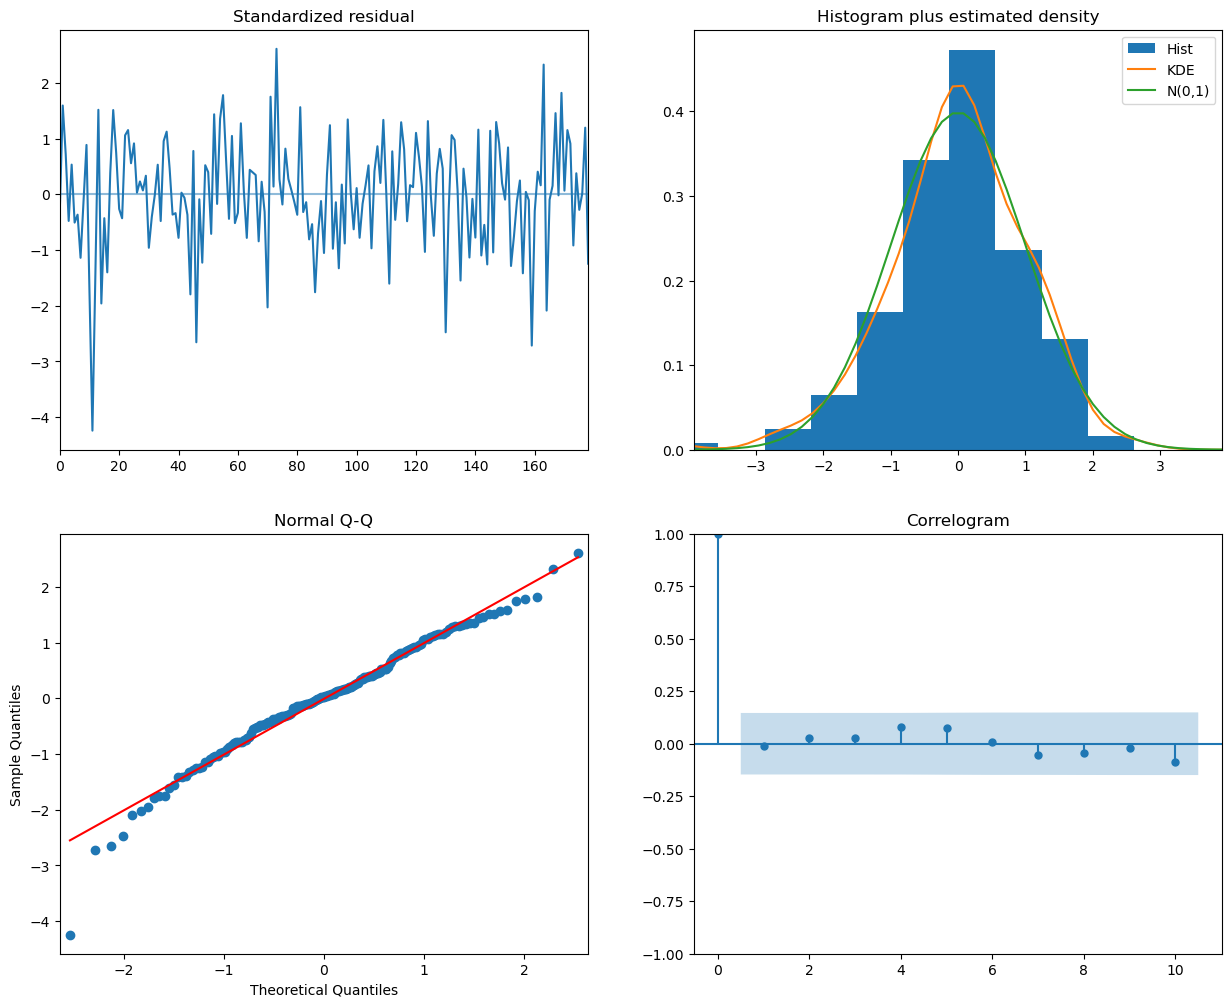

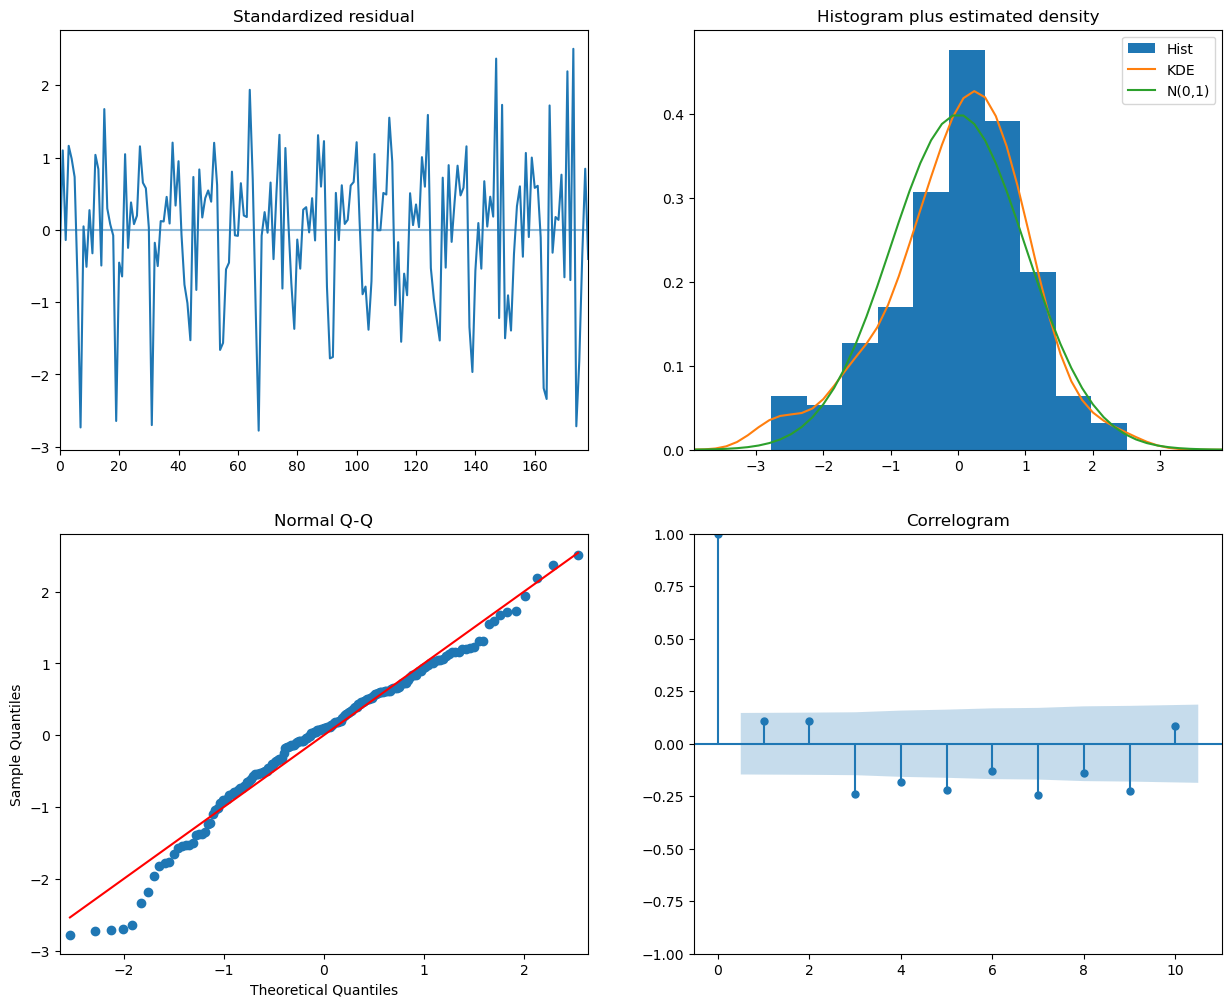

In [42]:
n_batch=1
X = []
y = []
temp = []
sh = []
PC1 = []
PC2 = []
PC3 = []
X_test = []
y_test = []
temp_test = []
sh_test = []
PC1_test = []
PC2_test = []
PC3_test = []
X_val = []
y_val = []
temp_val = []
sh_val = []
PC1_val = []
PC2_val = []
PC3_val = []

train1 = train[0]
test1 = test[0]
validation1 = validation[0]

# Aggregate the original data by getting the median of the weather station temperatures for each month
y_df = results_df.groupby(['Year', 'Month'])['temperatures'].median()
y1 = y_df.values

data = []
for j in range(len(train1)):
    ws_row = []
    for k in range(len(train1[0])):
        Q = train1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (temperature)
    data.append(ws_row) # Get single weather station's temperatures
for j in range(len(test1)):
    ws_row = []
    for k in range(len(test1[0])):
        Q = test1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (temperature)
    data.append(ws_row) # Get single weather station's temperatures
for j in range(len(validation1)):
    ws_row = []
    for k in range(len(validation1[0])):
        Q = validation1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (temperature)
    data.append(ws_row) # Get single weather station's temperatures

# Aggregate the transformed data by getting the median of the weather station temperatures for each month
y_scaled = []

for j in range(len(data[0])):
    ws_row = [] # holds all 105 weather station's temperatures for the same time step to get median value
    for k in range(len(data)):
        ws_row.append(data[k][j])
    y_scaled.append(np.median(ws_row))

# Plot data
plot_data(y1, "Temperature")

#Get rolling statistics
rolling_statistics(pd.DataFrame(y1))

# Run Dickey-Fuller test to check if stationary
ADF(y_scaled, "Temperature")
ADF(y1, "Temperature")

#Run Kruskal-Wallis H Test to check if the population median of each weather station is the same
kruskal_stat, kruskal_pval = kruskal(*[results_df[results_df['file_id'] == f]['temperatures'] for f in results_df['file_id'].unique()])

print(kruskal_stat)
print(kruskal_pval)
    
#Run Shapiro-Wilk Test for normality
normality_test_results = {}
for ws in results_df['file_id'].unique():
    w, pvalue = shapiro(results_df[results_df['file_id'] == ws]['temperatures'])
    normality_test_results[ws] = pvalue
        
# Levene's Test for homogeneity of variances
levene_stat, levene_p = levene(*[results_df[results_df['file_id'] == ws]['temperatures'] for ws in results_df['file_id'].unique()])

print("Shapiro-Wilk Test for Normality:")
print(normality_test_results)
print("Levene's Test for Homogeneity of Variances:")
print(levene_stat)
print("Levene p: "+str(levene_p))

# Generate ACF and PACF plots
fig1, axes1 = plt.subplots(2, 1, figsize=(14, 12))

print("Scaled Data:")

# Plot ACF
plot_acf(pd.DataFrame(y_scaled), ax=axes1[0], lags=30, alpha=0.05)
axes1[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(pd.DataFrame(y_scaled), ax=axes1[1], lags=30, alpha=0.05, method='ywm')
axes1[1].set_title('Partial Autocorrelation Function (PACF)')

print("Unscaled Data:")

# Generate ACF and PACF plots
fig2, axes2 = plt.subplots(2, 1, figsize=(14, 12))

# Plot ACF
plot_acf(y_df, ax=axes2[0], lags=30, alpha=0.05)
axes2[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(y_df, ax=axes2[1], lags=30, alpha=0.05, method='ywm')
axes2[1].set_title('Partial Autocorrelation Function (PACF)')

# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(y=results_df['temperatures'])
plt.title('Box Plot of Temperature')
plt.xlabel('Temperature')
plt.show()

# Decomposing the time series with an appropriate period based on the data's seasonality
decomposition_filled = seasonal_decompose(y_df, model='additive', period=12) # Monthly seasonality

# Plotting the decomposed components of the time series
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
decomposition_filled.trend.plot(ax=ax1)
ax1.set_title('Trend')
ax1.set_xlabel('Month')
ax1.set_ylabel('Temperature')

decomposition_filled.seasonal.plot(ax=ax2)
ax2.set_title('Seasonality')
ax2.set_xlabel('Month')
ax2.set_ylabel('Temperature')

decomposition_filled.resid.plot(ax=ax3)
ax3.set_title('Residuals')
ax3.set_xlabel('Month')
ax3.set_ylabel('Temperature')

plt.tight_layout()
plt.show()

# Transform data for ARIMA and SARIMAX

for i in range(5):

    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    
    # Transform training data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(train1, n_lag, n_seq)
    X.append(X_row)
    temp.append(temp_row)
    sh.append(sh_row)
    PC1.append(PC1_row)
    PC2.append(PC2_row)
    PC3.append(PC3_row)
    y.append(y_row)
    
    # Transform testing data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(test1, n_lag, n_seq)
    X_test.append(X_row)
    temp_test.append(temp_row)
    sh_test.append(sh_row)
    PC1_test.append(PC1_row)
    PC2_test.append(PC2_row)
    PC3_test.append(PC3_row)
    y_test.append(y_row)

    # Transform validation data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(validation1, n_lag, n_seq)
    X_val.append(X_row)
    temp_val.append(temp_row)
    sh_val.append(sh_row)
    PC1_val.append(PC1_row)
    PC2_val.append(PC2_row)
    PC3_val.append(PC3_row)
    y_val.append(y_row)

# Run models
    
# Predict temperature

# ARIMA model (for ARIMA model, all the SARIMAX model seasonal parameters are zero)

print("ARIMA Temperature Predictions:")

ARIMA_model_Temp, ARIMA_model_SH = fit_ARIMA_model(temp, temp_val, temp_test, sh, sh_val, sh_test, n_seq)

print(ARIMA_model_Temp.summary())
print(ARIMA_model_SH.summary())

plot_diagnostics(ARIMA_model_Temp)
plot_diagnostics(ARIMA_model_SH)

In [25]:
# SARIMAX Model
   
n_batch=1
X = []
y = []
temp = []
sh = []
PC1 = []
PC2 = []
PC3 = []
X_test = []
y_test = []
temp_test = []
sh_test = []
PC1_test = []
PC2_test = []
PC3_test = []
X_val = []
y_val = []
temp_val = []
sh_val = []
PC1_val = []
PC2_val = []
PC3_val = []

# Transform data for ARIMA and SARIMAX

for i in range(5):

    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    
    # Transform training data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(train1, n_lag, n_seq)
    X.append(X_row)
    temp.append(temp_row)
    sh.append(sh_row)
    PC1.append(PC1_row)
    PC2.append(PC2_row)
    PC3.append(PC3_row)
    y.append(y_row)
    
    # Transform testing data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(test1, n_lag, n_seq)
    X_test.append(X_row)
    temp_test.append(temp_row)
    sh_test.append(sh_row)
    PC1_test.append(PC1_row)
    PC2_test.append(PC2_row)
    PC3_test.append(PC3_row)
    y_test.append(y_row)

    # Transform validation data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(validation1, n_lag, n_seq)
    X_val.append(X_row)
    temp_val.append(temp_row)
    sh_val.append(sh_row)
    PC1_val.append(PC1_row)
    PC2_val.append(PC2_row)
    PC3_val.append(PC3_row)
    y_val.append(y_row)

SARIMAX_model_Temp, SARIMAX_model_SH = fit_SARIMAX_model(temp, temp_val, temp_test, sh, sh_val, sh_test, PC1, PC1_val, PC1_test, PC2, PC2_val, PC2_test, PC3, PC3_val, PC3_test, n_seq)

print(SARIMAX_model_Temp.summary())
print(SARIMAX_model_SH.summary())

84
10
11
84


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 169.633
Date:                                 Mon, 26 May 2025   AIC                           -323.266
Time:                                         09:02:57   BIC                           -297.766
Sample:                                              0   HQIC                          -312.926
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.007      0.326      0.745      -0.011       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 3)x(2, 0, [1, 2], 12)   Log Likelihood                 210.591
Date:                                 Mon, 26 May 2025   AIC                           -403.182
Time:                                         09:02:58   BIC                           -374.496
Sample:                                              0   HQIC                          -391.550
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0013      0.002      0.717      0.474      -0.002       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 203.052
Date:                              Mon, 26 May 2025   AIC                           -394.105
Time:                                      09:03:37   BIC                           -374.981
Sample:                                           0   HQIC                          -386.350
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0067      0.004      1.503      0.133      -0.002       0.015
ar.L1         -0.27

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 237.844
Date:                              Mon, 26 May 2025   AIC                           -463.688
Time:                                      09:03:37   BIC                           -444.563
Sample:                                           0   HQIC                          -455.933
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.384      0.701      -0.001       0.001
ar.L1          0.14

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 195.059
Date:                              Mon, 26 May 2025   AIC                           -380.117
Time:                                      09:04:10   BIC                           -364.180
Sample:                                           0   HQIC                          -373.655
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0050      0.004      1.181      0.238      -0.003       0.013
ar.L1         -0.24

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    09:04:10   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 203.585
Date:                            Mon, 26 May 2025   AIC                           -389.170
Time:                                    09:05:13   BIC                           -360.484
Sample:                                         0   HQIC                          -377.538
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0161      0.010      1.604      0.109      -0.004       0.036
ar.L1         -0.4655      0.244   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 237.844
Date:                              Mon, 26 May 2025   AIC                           -463.688
Time:                                      09:05:14   BIC                           -444.563
Sample:                                           0   HQIC                          -455.933
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.384      0.701      -0.001       0.001
ar.L1          0.14

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 210.895
Date:                              Mon, 26 May 2025   AIC                           -407.789
Time:                                      09:06:08   BIC                           -385.477
Sample:                                           0   HQIC                          -398.742
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.418      0.156      -0.002       0.010
ar.L1          0.01

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 262.195
Date:                            Mon, 26 May 2025   AIC                           -512.390
Time:                                    09:06:09   BIC                           -493.265
Sample:                                         0   HQIC                          -504.635
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.844      0.399      -0.001       0.002
ma.L1         -0.4374      0.063   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 210.895
Date:                              Mon, 26 May 2025   AIC                           -407.789
Time:                                      09:07:18   BIC                           -385.477
Sample:                                           0   HQIC                          -398.742
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.418      0.156      -0.002       0.010
ar.L1          0.01

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    09:07:18   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 212.107
Date:                              Mon, 26 May 2025   AIC                           -406.214
Time:                                      09:08:55   BIC                           -377.528
Sample:                                           0   HQIC                          -394.582
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0039      0.034      0.113      0.910      -0.063       0.071
ar.L1         -0.43

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 3)x(2, 0, [1], 12)   Log Likelihood                 247.947
Date:                              Mon, 26 May 2025   AIC                           -475.894
Time:                                      09:08:56   BIC                           -444.020
Sample:                                           0   HQIC                          -462.970
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      0.771      0.441      -0.001       0.003
ar.L1         -0.82

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 195.059
Date:                              Mon, 26 May 2025   AIC                           -380.117
Time:                                      09:09:25   BIC                           -364.180
Sample:                                           0   HQIC                          -373.655
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0050      0.004      1.181      0.238      -0.003       0.013
ar.L1         -0.24

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(2, 0, [1], 12)   Log Likelihood                 265.351
Date:                              Mon, 26 May 2025   AIC                           -516.702
Time:                                      09:09:26   BIC                           -494.390
Sample:                                           0   HQIC                          -507.655
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.002      0.592      0.554      -0.002       0.004
ar.L1         -0.29

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 197.305
Date:                            Mon, 26 May 2025   AIC                           -378.611
Time:                                    09:10:27   BIC                           -353.112
Sample:                                         0   HQIC                          -368.271
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0114      0.005      2.124      0.034       0.001       0.022
ar.L1         -0.3421      0.261   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 259.695
Date:                            Mon, 26 May 2025   AIC                           -507.390
Time:                                    09:10:27   BIC                           -488.266
Sample:                                         0   HQIC                          -499.635
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.001      0.230      0.818      -0.002       0.003
ar.L1          0.3077      0.350   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 12)   Log Likelihood                 212.761
Date:                              Mon, 26 May 2025   AIC                           -409.523
Time:                                      09:11:46   BIC                           -384.024
Sample:                                           0   HQIC                          -399.183
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0063      0.006      1.135      0.256      -0.005       0.017
ar.L1         -0.52

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 274.660
Date:                              Mon, 26 May 2025   AIC                           -537.319
Time:                                      09:11:47   BIC                           -518.195
Sample:                                           0   HQIC                          -529.565
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.785      0.433      -0.001       0.002
ma.L1         -0.53

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 207.579
Date:                              Mon, 26 May 2025   AIC                           -403.158
Time:                                      09:12:42   BIC                           -384.033
Sample:                                           0   HQIC                          -395.403
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.295      0.195      -0.002       0.010
ma.L1         -0.28

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Mon, 26 May 2025   AIC                           -501.774
Time:                                      09:12:43   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Mon, 26 May 2025   AIC                           -401.530
Time:                                    09:13:24   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 274.660
Date:                              Mon, 26 May 2025   AIC                           -537.319
Time:                                      09:13:25   BIC                           -518.195
Sample:                                           0   HQIC                          -529.565
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.785      0.433      -0.001       0.002
ma.L1         -0.53

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 210.895
Date:                              Mon, 26 May 2025   AIC                           -407.789
Time:                                      09:14:32   BIC                           -385.477
Sample:                                           0   HQIC                          -398.742
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.418      0.156      -0.002       0.010
ar.L1          0.01

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(2, 0, [1, 2], 12)   Log Likelihood                 224.739
Date:                                 Mon, 26 May 2025   AIC                           -433.477
Time:                                         09:14:33   BIC                           -407.978
Sample:                                              0   HQIC                          -423.138
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.003      0.049      0.961      -0.006       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 189.764
Date:                                 Mon, 26 May 2025   AIC                           -365.528
Time:                                         09:15:50   BIC                           -343.217
Sample:                                              0   HQIC                          -356.481
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0069      0.006      1.241      0.215      -0.004       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 274.660
Date:                              Mon, 26 May 2025   AIC                           -537.319
Time:                                      09:15:51   BIC                           -518.195
Sample:                                           0   HQIC                          -529.565
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.785      0.433      -0.001       0.002
ma.L1         -0.53

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 4)x(1, 0, [1], 12)   Log Likelihood                 206.738
Date:                              Mon, 26 May 2025   AIC                           -397.477
Time:                                      09:20:07   BIC                           -371.978
Sample:                                           0   HQIC                          -387.137
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.004      0.907      0.364      -0.005       0.013
ma.L1         -0.30

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Mon, 26 May 2025   AIC                           -501.774
Time:                                      09:20:09   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 210.784
Date:                              Mon, 26 May 2025   AIC                           -405.568
Time:                                      09:23:07   BIC                           -380.069
Sample:                                           0   HQIC                          -395.228
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.436      0.151      -0.001       0.009
ar.L1         -0.08

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                  179
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                 248.912
Date:                    Mon, 26 May 2025   AIC                           -489.825
Time:                            09:23:08   BIC                           -477.075
Sample:                                 0   HQIC                          -484.655
                                    - 179                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.007      0.314      -0.000       0.001
ar.S.L12       0.9990      0.001   1143.873      0.000       0.997       1.001
ma.S.L12      -0.740

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    09:24:29   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 244.413
Date:                              Mon, 26 May 2025   AIC                           -478.826
Time:                                      09:24:30   BIC                           -462.890
Sample:                                           0   HQIC                          -472.364
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.002      0.165      0.869      -0.004       0.005
ar.L1          0.13

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 210.895
Date:                              Mon, 26 May 2025   AIC                           -407.789
Time:                                      09:28:09   BIC                           -385.477
Sample:                                           0   HQIC                          -398.742
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.418      0.156      -0.002       0.010
ar.L1          0.01

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 257.587
Date:                                 Mon, 26 May 2025   AIC                           -499.174
Time:                                         09:28:11   BIC                           -473.675
Sample:                                              0   HQIC                          -488.834
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      0.775      0.438      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    09:30:08   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    09:30:09   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                   SARIMAX Results                                   
Dep. Variable:                             y   No. Observations:                  179
Model:             SARIMAX(2, 0, [1, 2], 12)   Log Likelihood                 191.823
Date:                       Mon, 26 May 2025   AIC                           -371.646
Time:                               09:31:53   BIC                           -352.521
Sample:                                    0   HQIC                          -363.891
                                       - 179                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0030      0.015      0.196      0.844      -0.027       0.033
ar.S.L12       0.3825      7.013      0.055      0.956     -13.362      14.

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Mon, 26 May 2025   AIC                           -501.774
Time:                                      09:31:55   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 184.536
Date:                              Mon, 26 May 2025   AIC                           -355.072
Time:                                      09:36:41   BIC                           -332.760
Sample:                                           0   HQIC                          -346.025
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0028      0.003      0.941      0.347      -0.003       0.009
ar.L1          0.06

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(5, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 265.858
Date:                            Mon, 26 May 2025   AIC                           -509.715
Time:                                    09:36:51   BIC                           -474.654
Sample:                                         0   HQIC                          -495.498
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0017      0.002      0.821      0.412      -0.002       0.006
ar.L1         -0.2203      0.392   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 203.585
Date:                            Mon, 26 May 2025   AIC                           -389.170
Time:                                    09:40:35   BIC                           -360.484
Sample:                                         0   HQIC                          -377.538
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0161      0.010      1.604      0.109      -0.004       0.036
ar.L1         -0.4655      0.244   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 237.844
Date:                              Mon, 26 May 2025   AIC                           -463.688
Time:                                      09:40:38   BIC                           -444.563
Sample:                                           0   HQIC                          -455.933
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.384      0.701      -0.001       0.001
ar.L1          0.14

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 203.585
Date:                            Mon, 26 May 2025   AIC                           -389.170
Time:                                    09:43:47   BIC                           -360.484
Sample:                                         0   HQIC                          -377.538
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0161      0.010      1.604      0.109      -0.004       0.036
ar.L1         -0.4655      0.244   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    09:43:49   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 195.059
Date:                              Mon, 26 May 2025   AIC                           -380.117
Time:                                      09:45:11   BIC                           -364.180
Sample:                                           0   HQIC                          -373.655
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0050      0.004      1.181      0.238      -0.003       0.013
ar.L1         -0.24

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 237.844
Date:                              Mon, 26 May 2025   AIC                           -463.688
Time:                                      09:45:12   BIC                           -444.563
Sample:                                           0   HQIC                          -455.933
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.384      0.701      -0.001       0.001
ar.L1          0.14

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    09:47:30   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(2, 0, [1], 12)   Log Likelihood                 266.975
Date:                              Mon, 26 May 2025   AIC                           -517.949
Time:                                      09:47:33   BIC                           -492.450
Sample:                                           0   HQIC                          -507.610
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.002      0.539      0.590      -0.003       0.005
ar.L1         -0.32

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 203.585
Date:                            Mon, 26 May 2025   AIC                           -389.170
Time:                                    09:50:27   BIC                           -360.484
Sample:                                         0   HQIC                          -377.538
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0161      0.010      1.604      0.109      -0.004       0.036
ar.L1         -0.4655      0.244   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 237.844
Date:                              Mon, 26 May 2025   AIC                           -463.688
Time:                                      09:50:29   BIC                           -444.563
Sample:                                           0   HQIC                          -455.933
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.384      0.701      -0.001       0.001
ar.L1          0.14

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 199.931
Date:                                 Mon, 26 May 2025   AIC                           -385.862
Time:                                         09:53:01   BIC                           -363.551
Sample:                                              0   HQIC                          -376.815
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0073      0.004      1.689      0.091      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 274.660
Date:                              Mon, 26 May 2025   AIC                           -537.319
Time:                                      09:53:03   BIC                           -518.195
Sample:                                           0   HQIC                          -529.565
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.785      0.433      -0.001       0.002
ma.L1         -0.53

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    09:55:42   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 257.587
Date:                                 Mon, 26 May 2025   AIC                           -499.174
Time:                                         09:55:45   BIC                           -473.675
Sample:                                              0   HQIC                          -488.834
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      0.775      0.438      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    09:57:50   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Mon, 26 May 2025   AIC                           -501.774
Time:                                      09:57:51   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    10:00:24   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                  80.124
Date:                              Mon, 26 May 2025   AIC                           -144.249
Time:                                      10:00:26   BIC                           -118.750
Sample:                                           0   HQIC                          -133.909
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0061      0.050     -0.122      0.903      -0.104       0.092
ar.L1          0.12

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Mon, 26 May 2025   AIC                           -401.530
Time:                                    10:02:12   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(2, 0, [1], 12)   Log Likelihood                 265.351
Date:                              Mon, 26 May 2025   AIC                           -516.702
Time:                                      10:02:16   BIC                           -494.390
Sample:                                           0   HQIC                          -507.655
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.002      0.592      0.554      -0.002       0.004
ar.L1         -0.29

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Mon, 26 May 2025   AIC                           -401.530
Time:                                    10:04:36   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    10:04:39   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    10:06:19   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 247.760
Date:                            Mon, 26 May 2025   AIC                           -481.520
Time:                                    10:06:23   BIC                           -459.209
Sample:                                         0   HQIC                          -472.473
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.003      0.678      0.498      -0.004       0.008
ma.L1          0.0420      0.092   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 189.764
Date:                                 Mon, 26 May 2025   AIC                           -365.528
Time:                                         10:08:20   BIC                           -343.217
Sample:                                              0   HQIC                          -356.481
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0069      0.006      1.241      0.215      -0.004       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [], 12)   Log Likelihood                 248.690
Date:                             Mon, 26 May 2025   AIC                           -487.379
Time:                                     10:08:21   BIC                           -471.442
Sample:                                          0   HQIC                          -480.917
                                             - 179                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.002      1.278      0.201      -0.001       0.006
ma.L1         -0.6444      

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 197.305
Date:                            Mon, 26 May 2025   AIC                           -378.611
Time:                                    10:11:01   BIC                           -353.112
Sample:                                         0   HQIC                          -368.271
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0114      0.005      2.124      0.034       0.001       0.022
ar.L1         -0.3421      0.261   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 267.038
Date:                                 Mon, 26 May 2025   AIC                           -522.076
Time:                                         10:11:07   BIC                           -502.952
Sample:                                              0   HQIC                          -514.321
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0021      0.002      1.162      0.245      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                  179
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                 190.365
Date:                    Mon, 26 May 2025   AIC                           -372.729
Time:                            10:14:17   BIC                           -359.980
Sample:                                 0   HQIC                          -367.559
                                    - 179                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0042      0.004      1.098      0.272      -0.003       0.012
ar.S.L12       0.9917      0.008    130.572      0.000       0.977       1.007
ma.S.L12      -0.776

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 241.629
Date:                              Mon, 26 May 2025   AIC                           -465.258
Time:                                      10:14:23   BIC                           -436.572
Sample:                                           0   HQIC                          -453.626
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.001      0.482      0.630      -0.001       0.002
ar.L1         -0.20

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 199.931
Date:                                 Mon, 26 May 2025   AIC                           -385.862
Time:                                         10:17:09   BIC                           -363.551
Sample:                                              0   HQIC                          -376.815
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0073      0.004      1.689      0.091      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    10:17:09   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 203.052
Date:                              Mon, 26 May 2025   AIC                           -394.105
Time:                                      10:19:56   BIC                           -374.981
Sample:                                           0   HQIC                          -386.350
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0067      0.004      1.503      0.133      -0.002       0.015
ar.L1         -0.27

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 274.660
Date:                              Mon, 26 May 2025   AIC                           -537.319
Time:                                      10:19:58   BIC                           -518.195
Sample:                                           0   HQIC                          -529.565
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.785      0.433      -0.001       0.002
ma.L1         -0.53

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 209.703
Date:                            Mon, 26 May 2025   AIC                           -403.405
Time:                                    10:23:14   BIC                           -377.906
Sample:                                         0   HQIC                          -393.066
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0089      0.005      1.720      0.085      -0.001       0.019
ma.L1         -0.5560      0.085   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 265.192
Date:                            Mon, 26 May 2025   AIC                           -516.383
Time:                                    10:23:23   BIC                           -494.071
Sample:                                         0   HQIC                          -507.336
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.846      0.398      -0.001       0.002
ar.L1         -0.0965      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 213.913
Date:                            Mon, 26 May 2025   AIC                           -413.825
Time:                                    10:25:43   BIC                           -391.514
Sample:                                         0   HQIC                          -404.778
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.002      1.206      0.228      -0.001       0.005
ar.L1          0.4942      0.098   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 259.695
Date:                            Mon, 26 May 2025   AIC                           -507.390
Time:                                    10:25:47   BIC                           -488.266
Sample:                                         0   HQIC                          -499.635
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.001      0.230      0.818      -0.002       0.003
ar.L1          0.3077      0.350   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 169.633
Date:                                 Mon, 26 May 2025   AIC                           -323.266
Time:                                         10:29:21   BIC                           -297.766
Sample:                                              0   HQIC                          -312.926
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.007      0.326      0.745      -0.011       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    10:29:21   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 189.764
Date:                                 Mon, 26 May 2025   AIC                           -365.528
Time:                                         10:32:29   BIC                           -343.217
Sample:                                              0   HQIC                          -356.481
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0069      0.006      1.241      0.215      -0.004       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Mon, 26 May 2025   AIC                           -501.774
Time:                                      10:32:31   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Mon, 26 May 2025   AIC                           -401.530
Time:                                    10:36:09   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(4, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 245.186
Date:                              Mon, 26 May 2025   AIC                           -474.372
Time:                                      10:36:11   BIC                           -448.873
Sample:                                           0   HQIC                          -464.033
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.001      0.898      0.369      -0.001       0.003
ar.L1         -0.22

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Mon, 26 May 2025   AIC                           -401.530
Time:                                    10:38:57   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(3, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 245.285
Date:                            Mon, 26 May 2025   AIC                           -474.569
Time:                                    10:39:00   BIC                           -449.070
Sample:                                         0   HQIC                          -464.230
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      0.760      0.447      -0.000       0.001
ar.L1         -0.0249      0.003   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 12)   Log Likelihood                 212.761
Date:                              Mon, 26 May 2025   AIC                           -409.523
Time:                                      10:41:23   BIC                           -384.024
Sample:                                           0   HQIC                          -399.183
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0063      0.006      1.135      0.256      -0.005       0.017
ar.L1         -0.52

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    10:41:24   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(4, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 203.876
Date:                              Mon, 26 May 2025   AIC                           -391.752
Time:                                      10:45:31   BIC                           -366.253
Sample:                                           0   HQIC                          -381.413
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0077      0.006      1.360      0.174      -0.003       0.019
ar.L1         -0.40

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(5, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 259.007
Date:                              Mon, 26 May 2025   AIC                           -500.014
Time:                                      10:45:34   BIC                           -471.327
Sample:                                           0   HQIC                          -488.382
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0014      0.002      0.841      0.400      -0.002       0.005
ar.L1         -0.32

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 197.305
Date:                            Mon, 26 May 2025   AIC                           -378.611
Time:                                    10:50:49   BIC                           -353.112
Sample:                                         0   HQIC                          -368.271
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0114      0.005      2.124      0.034       0.001       0.022
ar.L1         -0.3421      0.261   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 266.526
Date:                            Mon, 26 May 2025   AIC                           -517.052
Time:                                    10:50:51   BIC                           -491.553
Sample:                                         0   HQIC                          -506.712
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0026      0.003      0.963      0.335      -0.003       0.008
ar.L1         -0.2545      0.657   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 191.738
Date:                            Mon, 26 May 2025   AIC                           -369.477
Time:                                    10:52:51   BIC                           -347.165
Sample:                                         0   HQIC                          -360.430
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0086      0.005      1.769      0.077      -0.001       0.018
ma.L1         -0.1920      0.081   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(2, 0, [1], 12)   Log Likelihood                 266.975
Date:                              Mon, 26 May 2025   AIC                           -517.949
Time:                                      10:52:56   BIC                           -492.450
Sample:                                           0   HQIC                          -507.610
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.002      0.539      0.590      -0.003       0.005
ar.L1         -0.32

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 189.764
Date:                                 Mon, 26 May 2025   AIC                           -365.528
Time:                                         10:55:47   BIC                           -343.217
Sample:                                              0   HQIC                          -356.481
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0069      0.006      1.241      0.215      -0.004       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                  80.124
Date:                              Mon, 26 May 2025   AIC                           -144.249
Time:                                      10:55:49   BIC                           -118.750
Sample:                                           0   HQIC                          -133.909
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0061      0.050     -0.122      0.903      -0.104       0.092
ar.L1          0.12

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                  179
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                 190.365
Date:                    Mon, 26 May 2025   AIC                           -372.729
Time:                            10:58:37   BIC                           -359.980
Sample:                                 0   HQIC                          -367.559
                                    - 179                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0042      0.004      1.098      0.272      -0.003       0.012
ar.S.L12       0.9917      0.008    130.572      0.000       0.977       1.007
ma.S.L12      -0.776

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 3)x(2, 0, [1], 12)   Log Likelihood                 227.284
Date:                              Mon, 26 May 2025   AIC                           -436.567
Time:                                      10:58:46   BIC                           -407.881
Sample:                                           0   HQIC                          -424.935
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.001      0.571      0.568      -0.001       0.002
ar.L1         -0.69

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(4, 0, 1)   Log Likelihood                 182.523
Date:                Mon, 26 May 2025   AIC                           -351.046
Time:                        11:02:21   BIC                           -328.735
Sample:                             0   HQIC                          -341.999
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3162      0.019     16.336      0.000       0.278       0.354
ar.L1          0.9418      0.057     16.562      0.000       0.830       1.053
ar.L2         -0.1986      0.082     -2.417      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 262.195
Date:                            Mon, 26 May 2025   AIC                           -512.390
Time:                                    11:02:22   BIC                           -493.265
Sample:                                         0   HQIC                          -504.635
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.844      0.399      -0.001       0.002
ma.L1         -0.4374      0.063   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 169.633
Date:                                 Mon, 26 May 2025   AIC                           -323.266
Time:                                         11:04:23   BIC                           -297.766
Sample:                                              0   HQIC                          -312.926
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.007      0.326      0.745      -0.011       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    11:04:24   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 191.738
Date:                            Mon, 26 May 2025   AIC                           -369.477
Time:                                    11:06:09   BIC                           -347.165
Sample:                                         0   HQIC                          -360.430
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0086      0.005      1.769      0.077      -0.001       0.018
ma.L1         -0.1920      0.081   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [], 12)   Log Likelihood                 248.690
Date:                             Mon, 26 May 2025   AIC                           -487.379
Time:                                     11:06:11   BIC                           -471.442
Sample:                                          0   HQIC                          -480.917
                                             - 179                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.002      1.278      0.201      -0.001       0.006
ma.L1         -0.6444      

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    11:08:11   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    11:08:12   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 201.090
Date:                              Mon, 26 May 2025   AIC                           -388.179
Time:                                      11:10:14   BIC                           -365.868
Sample:                                           0   HQIC                          -379.132
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0051      0.007      0.758      0.448      -0.008       0.018
ma.L1         -0.43

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    11:10:14   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 199.931
Date:                                 Mon, 26 May 2025   AIC                           -385.862
Time:                                         11:12:58   BIC                           -363.551
Sample:                                              0   HQIC                          -376.815
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0073      0.004      1.689      0.091      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                  80.124
Date:                              Mon, 26 May 2025   AIC                           -144.249
Time:                                      11:12:59   BIC                           -118.750
Sample:                                           0   HQIC                          -133.909
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0061      0.050     -0.122      0.903      -0.104       0.092
ar.L1          0.12

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 209.703
Date:                            Mon, 26 May 2025   AIC                           -403.405
Time:                                    11:15:17   BIC                           -377.906
Sample:                                         0   HQIC                          -393.066
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0089      0.005      1.720      0.085      -0.001       0.019
ma.L1         -0.5560      0.085   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    11:15:19   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 195.059
Date:                              Mon, 26 May 2025   AIC                           -380.117
Time:                                      11:17:06   BIC                           -364.180
Sample:                                           0   HQIC                          -373.655
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0050      0.004      1.181      0.238      -0.003       0.013
ar.L1         -0.24

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 262.229
Date:                              Mon, 26 May 2025   AIC                           -510.458
Time:                                      11:17:09   BIC                           -488.147
Sample:                                           0   HQIC                          -501.411
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.001      0.717      0.473      -0.001       0.003
ar.L1         -0.55

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    11:19:48   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 262.229
Date:                              Mon, 26 May 2025   AIC                           -510.458
Time:                                      11:19:51   BIC                           -488.147
Sample:                                           0   HQIC                          -501.411
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.001      0.717      0.473      -0.001       0.003
ar.L1         -0.55

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    11:21:59   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 257.587
Date:                                 Mon, 26 May 2025   AIC                           -499.174
Time:                                         11:22:01   BIC                           -473.675
Sample:                                              0   HQIC                          -488.834
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      0.775      0.438      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 199.931
Date:                                 Mon, 26 May 2025   AIC                           -385.862
Time:                                         11:24:56   BIC                           -363.551
Sample:                                              0   HQIC                          -376.815
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0073      0.004      1.689      0.091      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 257.587
Date:                                 Mon, 26 May 2025   AIC                           -499.174
Time:                                         11:24:59   BIC                           -473.675
Sample:                                              0   HQIC                          -488.834
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      0.775      0.438      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    11:26:30   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    11:26:30   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 209.703
Date:                            Mon, 26 May 2025   AIC                           -403.405
Time:                                    11:28:33   BIC                           -377.906
Sample:                                         0   HQIC                          -393.066
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0089      0.005      1.720      0.085      -0.001       0.019
ma.L1         -0.5560      0.085   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 252.940
Date:                            Mon, 26 May 2025   AIC                           -487.880
Time:                                    11:28:38   BIC                           -459.194
Sample:                                         0   HQIC                          -476.248
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      0.931      0.352      -0.001       0.003
ar.L1         -0.3705      0.284   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    11:31:24   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 252.940
Date:                            Mon, 26 May 2025   AIC                           -487.880
Time:                                    11:31:27   BIC                           -459.194
Sample:                                         0   HQIC                          -476.248
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      0.931      0.352      -0.001       0.003
ar.L1         -0.3705      0.284   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 209.703
Date:                            Mon, 26 May 2025   AIC                           -403.405
Time:                                    11:34:33   BIC                           -377.906
Sample:                                         0   HQIC                          -393.066
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0089      0.005      1.720      0.085      -0.001       0.019
ma.L1         -0.5560      0.085   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(4, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 245.186
Date:                              Mon, 26 May 2025   AIC                           -474.372
Time:                                      11:34:34   BIC                           -448.873
Sample:                                           0   HQIC                          -464.033
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.001      0.898      0.369      -0.001       0.003
ar.L1         -0.22

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 191.738
Date:                            Mon, 26 May 2025   AIC                           -369.477
Time:                                    11:35:38   BIC                           -347.165
Sample:                                         0   HQIC                          -360.430
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0086      0.005      1.769      0.077      -0.001       0.018
ma.L1         -0.1920      0.081   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    11:35:39   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 210.784
Date:                              Mon, 26 May 2025   AIC                           -405.568
Time:                                      11:37:42   BIC                           -380.069
Sample:                                           0   HQIC                          -395.228
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.436      0.151      -0.001       0.009
ar.L1         -0.08

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                  179
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                 248.912
Date:                    Mon, 26 May 2025   AIC                           -489.825
Time:                            11:37:43   BIC                           -477.075
Sample:                                 0   HQIC                          -484.655
                                    - 179                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.007      0.314      -0.000       0.001
ar.S.L12       0.9990      0.001   1143.873      0.000       0.997       1.001
ma.S.L12      -0.740

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    11:39:42   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 262.229
Date:                              Mon, 26 May 2025   AIC                           -510.458
Time:                                      11:39:43   BIC                           -488.147
Sample:                                           0   HQIC                          -501.411
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.001      0.717      0.473      -0.001       0.003
ar.L1         -0.55

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Mon, 26 May 2025   AIC                           -401.530
Time:                                    11:41:19   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 274.660
Date:                              Mon, 26 May 2025   AIC                           -537.319
Time:                                      11:41:20   BIC                           -518.195
Sample:                                           0   HQIC                          -529.565
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.785      0.433      -0.001       0.002
ma.L1         -0.53

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 199.931
Date:                                 Mon, 26 May 2025   AIC                           -385.862
Time:                                         11:43:32   BIC                           -363.551
Sample:                                              0   HQIC                          -376.815
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0073      0.004      1.689      0.091      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 270.672
Date:                              Mon, 26 May 2025   AIC                           -527.344
Time:                                      11:43:35   BIC                           -505.032
Sample:                                           0   HQIC                          -518.297
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.012      0.312      -0.000       0.001
ma.L1         -0.61

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 4)x(2, 0, [1, 2], 12)   Log Likelihood                 204.739
Date:                                 Mon, 26 May 2025   AIC                           -389.477
Time:                                         11:46:27   BIC                           -357.604
Sample:                                              0   HQIC                          -376.553
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0089      0.011      0.824      0.410      -0.012       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    11:46:27   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 210.895
Date:                              Mon, 26 May 2025   AIC                           -407.789
Time:                                      11:49:36   BIC                           -385.477
Sample:                                           0   HQIC                          -398.742
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.418      0.156      -0.002       0.010
ar.L1          0.01

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 259.239
Date:                            Mon, 26 May 2025   AIC                           -502.478
Time:                                    11:49:39   BIC                           -476.979
Sample:                                         0   HQIC                          -492.138
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.002      0.476      0.634      -0.002       0.004
ar.L1         -0.3005      0.510   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 210.784
Date:                              Mon, 26 May 2025   AIC                           -405.568
Time:                                      11:52:00   BIC                           -380.069
Sample:                                           0   HQIC                          -395.228
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.436      0.151      -0.001       0.009
ar.L1         -0.08

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 267.038
Date:                                 Mon, 26 May 2025   AIC                           -522.076
Time:                                         11:52:04   BIC                           -502.952
Sample:                                              0   HQIC                          -514.321
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0021      0.002      1.162      0.245      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Mon, 26 May 2025   AIC                           -401.530
Time:                                    11:54:31   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 252.940
Date:                            Mon, 26 May 2025   AIC                           -487.880
Time:                                    11:54:40   BIC                           -459.194
Sample:                                         0   HQIC                          -476.248
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      0.931      0.352      -0.001       0.003
ar.L1         -0.3705      0.284   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 184.536
Date:                              Mon, 26 May 2025   AIC                           -355.072
Time:                                      11:56:09   BIC                           -332.760
Sample:                                           0   HQIC                          -346.025
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0028      0.003      0.941      0.347      -0.003       0.009
ar.L1          0.06

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 232.330
Date:                            Mon, 26 May 2025   AIC                           -456.660
Time:                                    11:56:10   BIC                           -443.910
Sample:                                         0   HQIC                          -451.490
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0446      0.016      2.761      0.006       0.013       0.076
ar.L1         -0.2606      0.066   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 169.633
Date:                                 Mon, 26 May 2025   AIC                           -323.266
Time:                                         11:59:00   BIC                           -297.766
Sample:                                              0   HQIC                          -312.926
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.007      0.326      0.745      -0.011       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 265.192
Date:                            Mon, 26 May 2025   AIC                           -516.383
Time:                                    11:59:03   BIC                           -494.071
Sample:                                         0   HQIC                          -507.336
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.846      0.398      -0.001       0.002
ar.L1         -0.0965      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 207.579
Date:                              Mon, 26 May 2025   AIC                           -403.158
Time:                                      12:02:17   BIC                           -384.033
Sample:                                           0   HQIC                          -395.403
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.295      0.195      -0.002       0.010
ma.L1         -0.28

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 265.192
Date:                            Mon, 26 May 2025   AIC                           -516.383
Time:                                    12:02:20   BIC                           -494.071
Sample:                                         0   HQIC                          -507.336
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.846      0.398      -0.001       0.002
ar.L1         -0.0965      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    12:04:34   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 252.940
Date:                            Mon, 26 May 2025   AIC                           -487.880
Time:                                    12:04:38   BIC                           -459.194
Sample:                                         0   HQIC                          -476.248
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      0.931      0.352      -0.001       0.003
ar.L1         -0.3705      0.284   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 209.703
Date:                            Mon, 26 May 2025   AIC                           -403.405
Time:                                    12:06:45   BIC                           -377.906
Sample:                                         0   HQIC                          -393.066
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0089      0.005      1.720      0.085      -0.001       0.019
ma.L1         -0.5560      0.085   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 267.999
Date:                                 Mon, 26 May 2025   AIC                           -521.998
Time:                                         12:06:48   BIC                           -499.686
Sample:                                              0   HQIC                          -512.951
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.003      0.436      0.663      -0.004       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 3)x(1, 0, [1], 12)   Log Likelihood                 203.443
Date:                              Mon, 26 May 2025   AIC                           -392.887
Time:                                      12:09:07   BIC                           -370.575
Sample:                                           0   HQIC                          -383.840
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0039      0.003      1.305      0.192      -0.002       0.010
ma.L1         -0.20

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 3)x(1, 0, [1], 12)   Log Likelihood                 267.092
Date:                              Mon, 26 May 2025   AIC                           -520.184
Time:                                      12:09:09   BIC                           -497.872
Sample:                                           0   HQIC                          -511.137
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.842      0.400      -0.001       0.002
ma.L1         -0.37

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 197.305
Date:                            Mon, 26 May 2025   AIC                           -378.611
Time:                                    12:11:28   BIC                           -353.112
Sample:                                         0   HQIC                          -368.271
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0114      0.005      2.124      0.034       0.001       0.022
ar.L1         -0.3421      0.261   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 237.844
Date:                              Mon, 26 May 2025   AIC                           -463.688
Time:                                      12:11:30   BIC                           -444.563
Sample:                                           0   HQIC                          -455.933
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.384      0.701      -0.001       0.001
ar.L1          0.14

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 197.305
Date:                            Mon, 26 May 2025   AIC                           -378.611
Time:                                    12:13:58   BIC                           -353.112
Sample:                                         0   HQIC                          -368.271
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0114      0.005      2.124      0.034       0.001       0.022
ar.L1         -0.3421      0.261   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 237.844
Date:                              Mon, 26 May 2025   AIC                           -463.688
Time:                                      12:13:59   BIC                           -444.563
Sample:                                           0   HQIC                          -455.933
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.384      0.701      -0.001       0.001
ar.L1          0.14

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 212.107
Date:                              Mon, 26 May 2025   AIC                           -406.214
Time:                                      12:16:37   BIC                           -377.528
Sample:                                           0   HQIC                          -394.582
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0039      0.034      0.113      0.910      -0.063       0.071
ar.L1         -0.43

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    12:16:38   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 203.052
Date:                              Mon, 26 May 2025   AIC                           -394.105
Time:                                      12:18:42   BIC                           -374.981
Sample:                                           0   HQIC                          -386.350
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0067      0.004      1.503      0.133      -0.002       0.015
ar.L1         -0.27

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 259.695
Date:                            Mon, 26 May 2025   AIC                           -507.390
Time:                                    12:18:43   BIC                           -488.266
Sample:                                         0   HQIC                          -499.635
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.001      0.230      0.818      -0.002       0.003
ar.L1          0.3077      0.350   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 213.913
Date:                            Mon, 26 May 2025   AIC                           -413.825
Time:                                    12:22:07   BIC                           -391.514
Sample:                                         0   HQIC                          -404.778
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.002      1.206      0.228      -0.001       0.005
ar.L1          0.4942      0.098   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(2, 0, [1], 12)   Log Likelihood                 266.975
Date:                              Mon, 26 May 2025   AIC                           -517.949
Time:                                      12:22:14   BIC                           -492.450
Sample:                                           0   HQIC                          -507.610
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.002      0.539      0.590      -0.003       0.005
ar.L1         -0.32

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 189.764
Date:                                 Mon, 26 May 2025   AIC                           -365.528
Time:                                         12:24:34   BIC                           -343.217
Sample:                                              0   HQIC                          -356.481
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0069      0.006      1.241      0.215      -0.004       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 257.587
Date:                                 Mon, 26 May 2025   AIC                           -499.174
Time:                                         12:24:36   BIC                           -473.675
Sample:                                              0   HQIC                          -488.834
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      0.775      0.438      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 210.784
Date:                              Mon, 26 May 2025   AIC                           -405.568
Time:                                      12:28:15   BIC                           -380.069
Sample:                                           0   HQIC                          -395.228
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.436      0.151      -0.001       0.009
ar.L1         -0.08

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 262.229
Date:                              Mon, 26 May 2025   AIC                           -510.458
Time:                                      12:28:18   BIC                           -488.147
Sample:                                           0   HQIC                          -501.411
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.001      0.717      0.473      -0.001       0.003
ar.L1         -0.55

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 169.633
Date:                                 Mon, 26 May 2025   AIC                           -323.266
Time:                                         12:30:53   BIC                           -297.766
Sample:                                              0   HQIC                          -312.926
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.007      0.326      0.745      -0.011       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 270.672
Date:                              Mon, 26 May 2025   AIC                           -527.344
Time:                                      12:30:56   BIC                           -505.032
Sample:                                           0   HQIC                          -518.297
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.012      0.312      -0.000       0.001
ma.L1         -0.61

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 199.931
Date:                                 Mon, 26 May 2025   AIC                           -385.862
Time:                                         12:36:04   BIC                           -363.551
Sample:                                              0   HQIC                          -376.815
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0073      0.004      1.689      0.091      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 247.760
Date:                            Mon, 26 May 2025   AIC                           -481.520
Time:                                    12:36:08   BIC                           -459.209
Sample:                                         0   HQIC                          -472.473
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.003      0.678      0.498      -0.004       0.008
ma.L1          0.0420      0.092   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 209.703
Date:                            Mon, 26 May 2025   AIC                           -403.405
Time:                                    12:39:32   BIC                           -377.906
Sample:                                         0   HQIC                          -393.066
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0089      0.005      1.720      0.085      -0.001       0.019
ma.L1         -0.5560      0.085   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 274.660
Date:                              Mon, 26 May 2025   AIC                           -537.319
Time:                                      12:39:35   BIC                           -518.195
Sample:                                           0   HQIC                          -529.565
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.785      0.433      -0.001       0.002
ma.L1         -0.53

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 191.738
Date:                            Mon, 26 May 2025   AIC                           -369.477
Time:                                    12:44:33   BIC                           -347.165
Sample:                                         0   HQIC                          -360.430
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0086      0.005      1.769      0.077      -0.001       0.018
ma.L1         -0.1920      0.081   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(4, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 266.879
Date:                            Mon, 26 May 2025   AIC                           -513.759
Time:                                    12:44:36   BIC                           -481.885
Sample:                                         0   HQIC                          -500.834
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      0.871      0.384      -0.001       0.003
ar.L1         -0.0341      0.177   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Mon, 26 May 2025   AIC                           -401.530
Time:                                    12:47:24   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 257.587
Date:                                 Mon, 26 May 2025   AIC                           -499.174
Time:                                         12:47:29   BIC                           -473.675
Sample:                                              0   HQIC                          -488.834
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      0.775      0.438      -0.001       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    12:49:30   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    12:49:32   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    12:52:06   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    12:52:08   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 201.090
Date:                              Mon, 26 May 2025   AIC                           -388.179
Time:                                      12:54:37   BIC                           -365.868
Sample:                                           0   HQIC                          -379.132
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0051      0.007      0.758      0.448      -0.008       0.018
ma.L1         -0.43

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Mon, 26 May 2025   AIC                           -501.774
Time:                                      12:54:38   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 3)x(2, 0, [1, 2], 12)   Log Likelihood                 169.791
Date:                                 Mon, 26 May 2025   AIC                           -321.581
Time:                                         12:58:15   BIC                           -292.895
Sample:                                              0   HQIC                          -309.949
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0089      0.006      1.601      0.109      -0.002       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Mon, 26 May 2025   AIC                           -501.774
Time:                                      12:58:16   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 213.913
Date:                            Mon, 26 May 2025   AIC                           -413.825
Time:                                    13:03:53   BIC                           -391.514
Sample:                                         0   HQIC                          -404.778
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.002      1.206      0.228      -0.001       0.005
ar.L1          0.4942      0.098   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                  80.124
Date:                              Mon, 26 May 2025   AIC                           -144.249
Time:                                      13:03:58   BIC                           -118.750
Sample:                                           0   HQIC                          -133.909
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0061      0.050     -0.122      0.903      -0.104       0.092
ar.L1          0.12

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 210.895
Date:                              Mon, 26 May 2025   AIC                           -407.789
Time:                                      13:07:46   BIC                           -385.477
Sample:                                           0   HQIC                          -398.742
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.418      0.156      -0.002       0.010
ar.L1          0.01

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Mon, 26 May 2025   AIC                           -501.774
Time:                                      13:07:49   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 207.579
Date:                              Mon, 26 May 2025   AIC                           -403.158
Time:                                      13:10:24   BIC                           -384.033
Sample:                                           0   HQIC                          -395.403
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.295      0.195      -0.002       0.010
ma.L1         -0.28

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, [], 12)   Log Likelihood                 100.362
Date:                             Mon, 26 May 2025   AIC                           -188.725
Time:                                     13:10:27   BIC                           -169.600
Sample:                                          0   HQIC                          -180.970
                                             - 179                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0082      0.005      1.546      0.122      -0.002       0.019
ma.L1          0.0146      

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.765
Date:                            Mon, 26 May 2025   AIC                           -401.530
Time:                                    13:13:02   BIC                           -382.406
Sample:                                         0   HQIC                          -393.775
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.406      0.160      -0.001       0.009
ar.L1          0.0909      0.121   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 268.822
Date:                            Mon, 26 May 2025   AIC                           -527.644
Time:                                    13:13:03   BIC                           -511.707
Sample:                                         0   HQIC                          -521.182
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.845      0.398      -0.001       0.002
ma.L1         -0.6458      0.053   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(2, 0, [1], 12)   Log Likelihood                 196.853
Date:                              Mon, 26 May 2025   AIC                           -379.705
Time:                                      13:15:49   BIC                           -357.393
Sample:                                           0   HQIC                          -370.658
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0060      0.006      1.013      0.311      -0.006       0.018
ar.L1         -0.13

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 12)   Log Likelihood                 256.343
Date:                             Mon, 26 May 2025   AIC                           -500.687
Time:                                     13:15:59   BIC                           -481.563
Sample:                                          0   HQIC                          -492.932
                                             - 179                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.001      1.391      0.164      -0.000       0.003
ar.L1          0.4810      

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    13:20:47   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 262.195
Date:                            Mon, 26 May 2025   AIC                           -512.390
Time:                                    13:20:52   BIC                           -493.265
Sample:                                         0   HQIC                          -504.635
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.844      0.399      -0.001       0.002
ma.L1         -0.4374      0.063   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 210.784
Date:                              Mon, 26 May 2025   AIC                           -405.568
Time:                                      13:24:30   BIC                           -380.069
Sample:                                           0   HQIC                          -395.228
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.436      0.151      -0.001       0.009
ar.L1         -0.08

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Mon, 26 May 2025   AIC                           -501.774
Time:                                      13:24:32   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 206.590
Date:                            Mon, 26 May 2025   AIC                           -403.179
Time:                                    13:28:26   BIC                           -387.242
Sample:                                         0   HQIC                          -396.717
                                            - 179                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.003      1.368      0.171      -0.002       0.009
ma.L1         -0.9518      0.022   

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 257.887
Date:                              Mon, 26 May 2025   AIC                           -501.774
Time:                                      13:28:29   BIC                           -479.463
Sample:                                           0   HQIC                          -492.727
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.904      0.366      -0.001       0.002
ar.L1         -0.26

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 169.633
Date:                                 Mon, 26 May 2025   AIC                           -323.266
Time:                                         13:32:02   BIC                           -297.766
Sample:                                              0   HQIC                          -312.926
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.007      0.326      0.745      -0.011       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(0, 0, 2)x(2, 0, [1], 12)   Log Likelihood                 270.672
Date:                              Mon, 26 May 2025   AIC                           -527.344
Time:                                      13:32:04   BIC                           -505.032
Sample:                                           0   HQIC                          -518.297
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.012      0.312      -0.000       0.001
ma.L1         -0.61

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


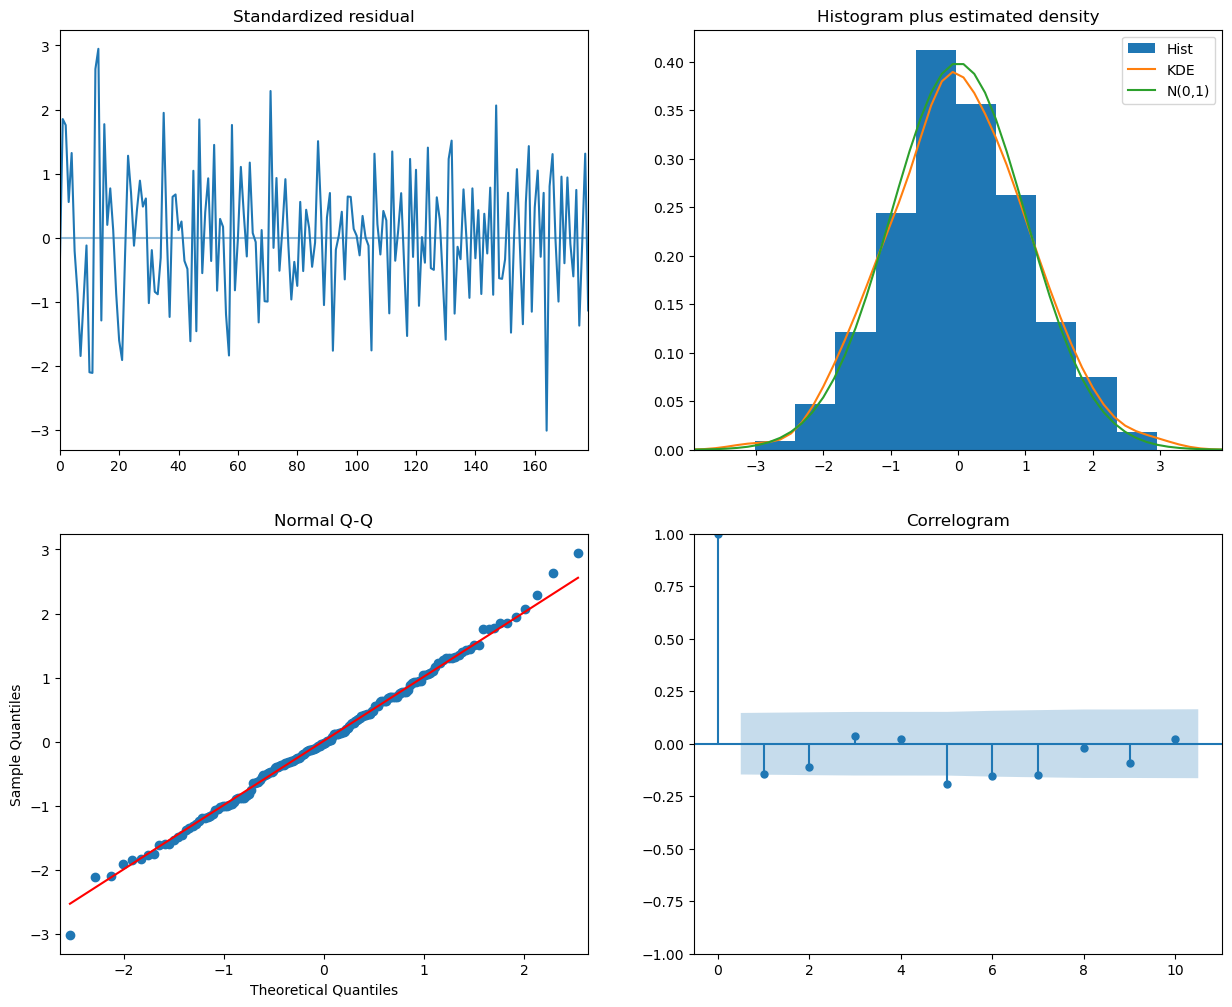

In [27]:
plot_diagnostics(SARIMAX_model_Temp)

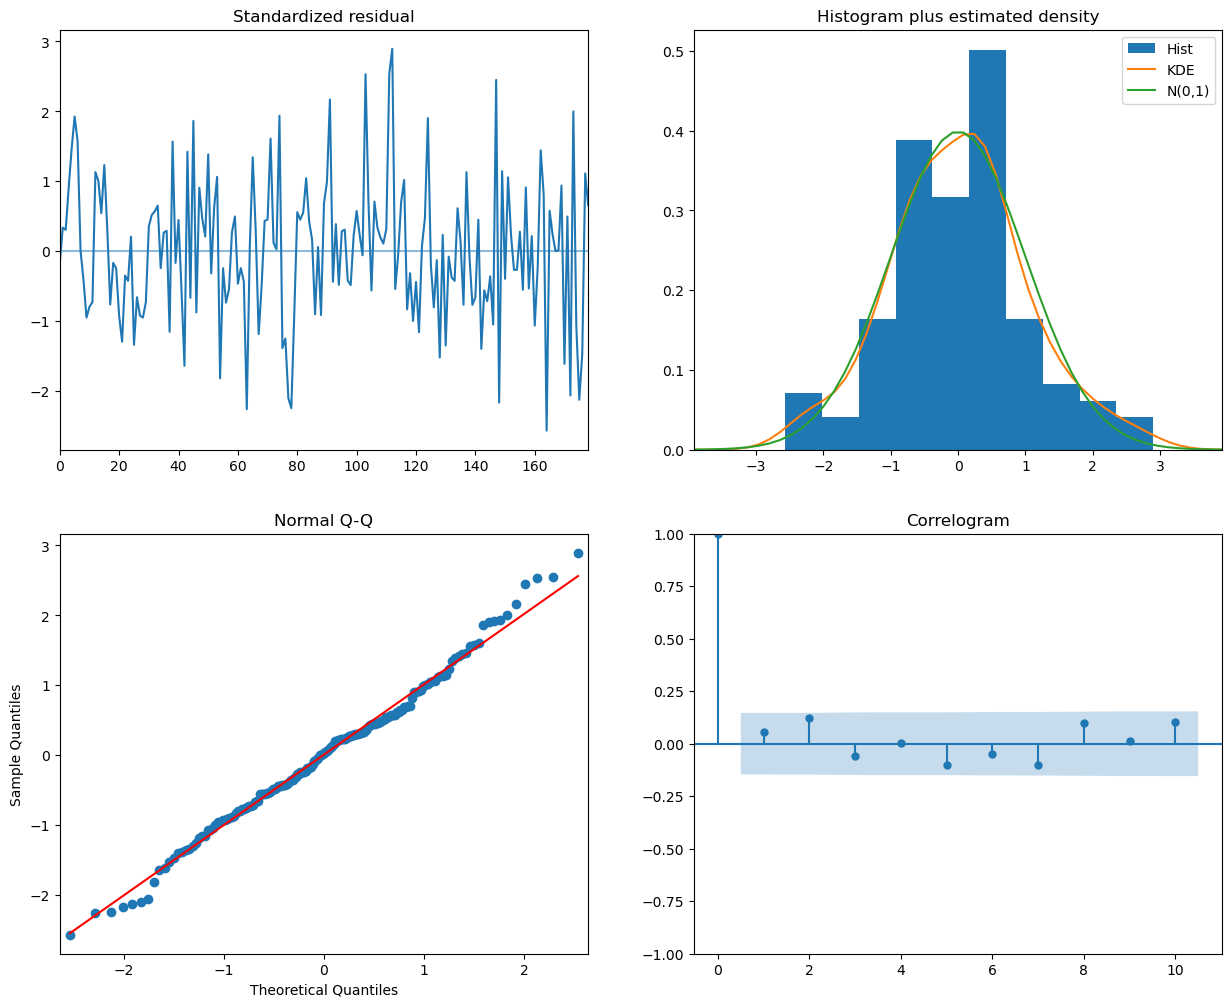

In [28]:
plot_diagnostics(SARIMAX_model_SH)